In [1]:
# --- Imports ---
import os
import sys
import random
import pickle
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_romo import WorkingMemoryEnv
from actor_critic_song import ActorCriticAgent
from reinforce_song import train_agent
from helper_functions import plot_metrics, plot_performance_matrix, plot_mean_firing_rate_trace, plot_activity_by_stimulus_class, sesgo_contraccion, load_model, save_model 

# --- Set Random Seeds ---
seed_value = 1
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

2025-08-25 11:26:47.588594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756114008.688427   10792 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756114008.997165   10792 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756114011.747292   10792 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756114011.747318   10792 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756114011.747320   10792 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/Modules' to sys.path
Setup Complete.


### STEP 1


Loading results from /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/outputs/WM+_F_rnn.pkl for plotting...
Timesteps para F1: [1]
Timesteps para F2: [3]

Plotting neural activity by stimulus class...


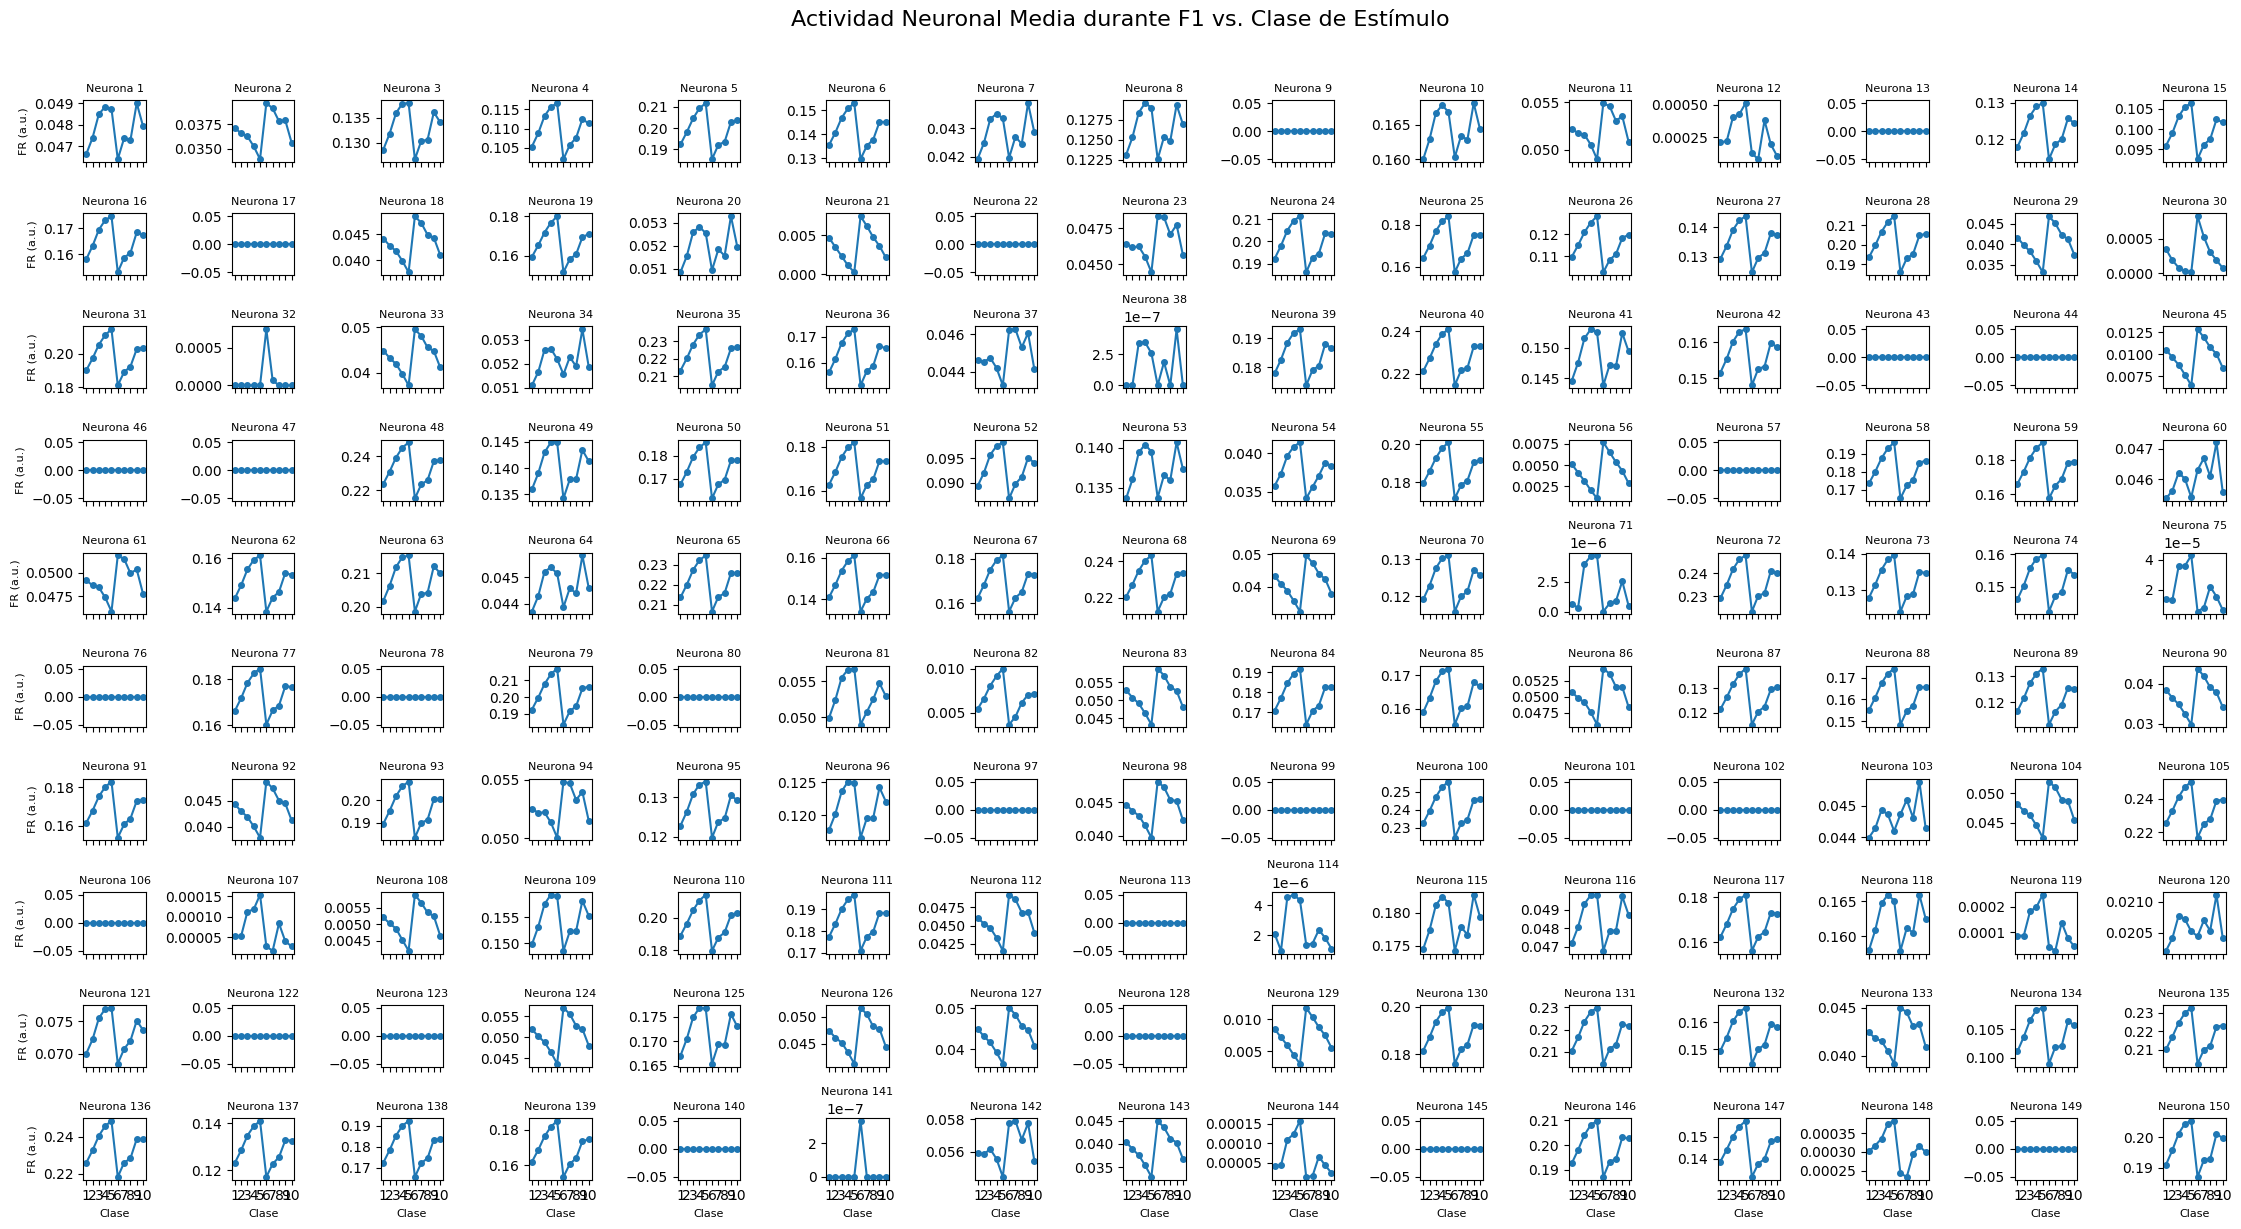

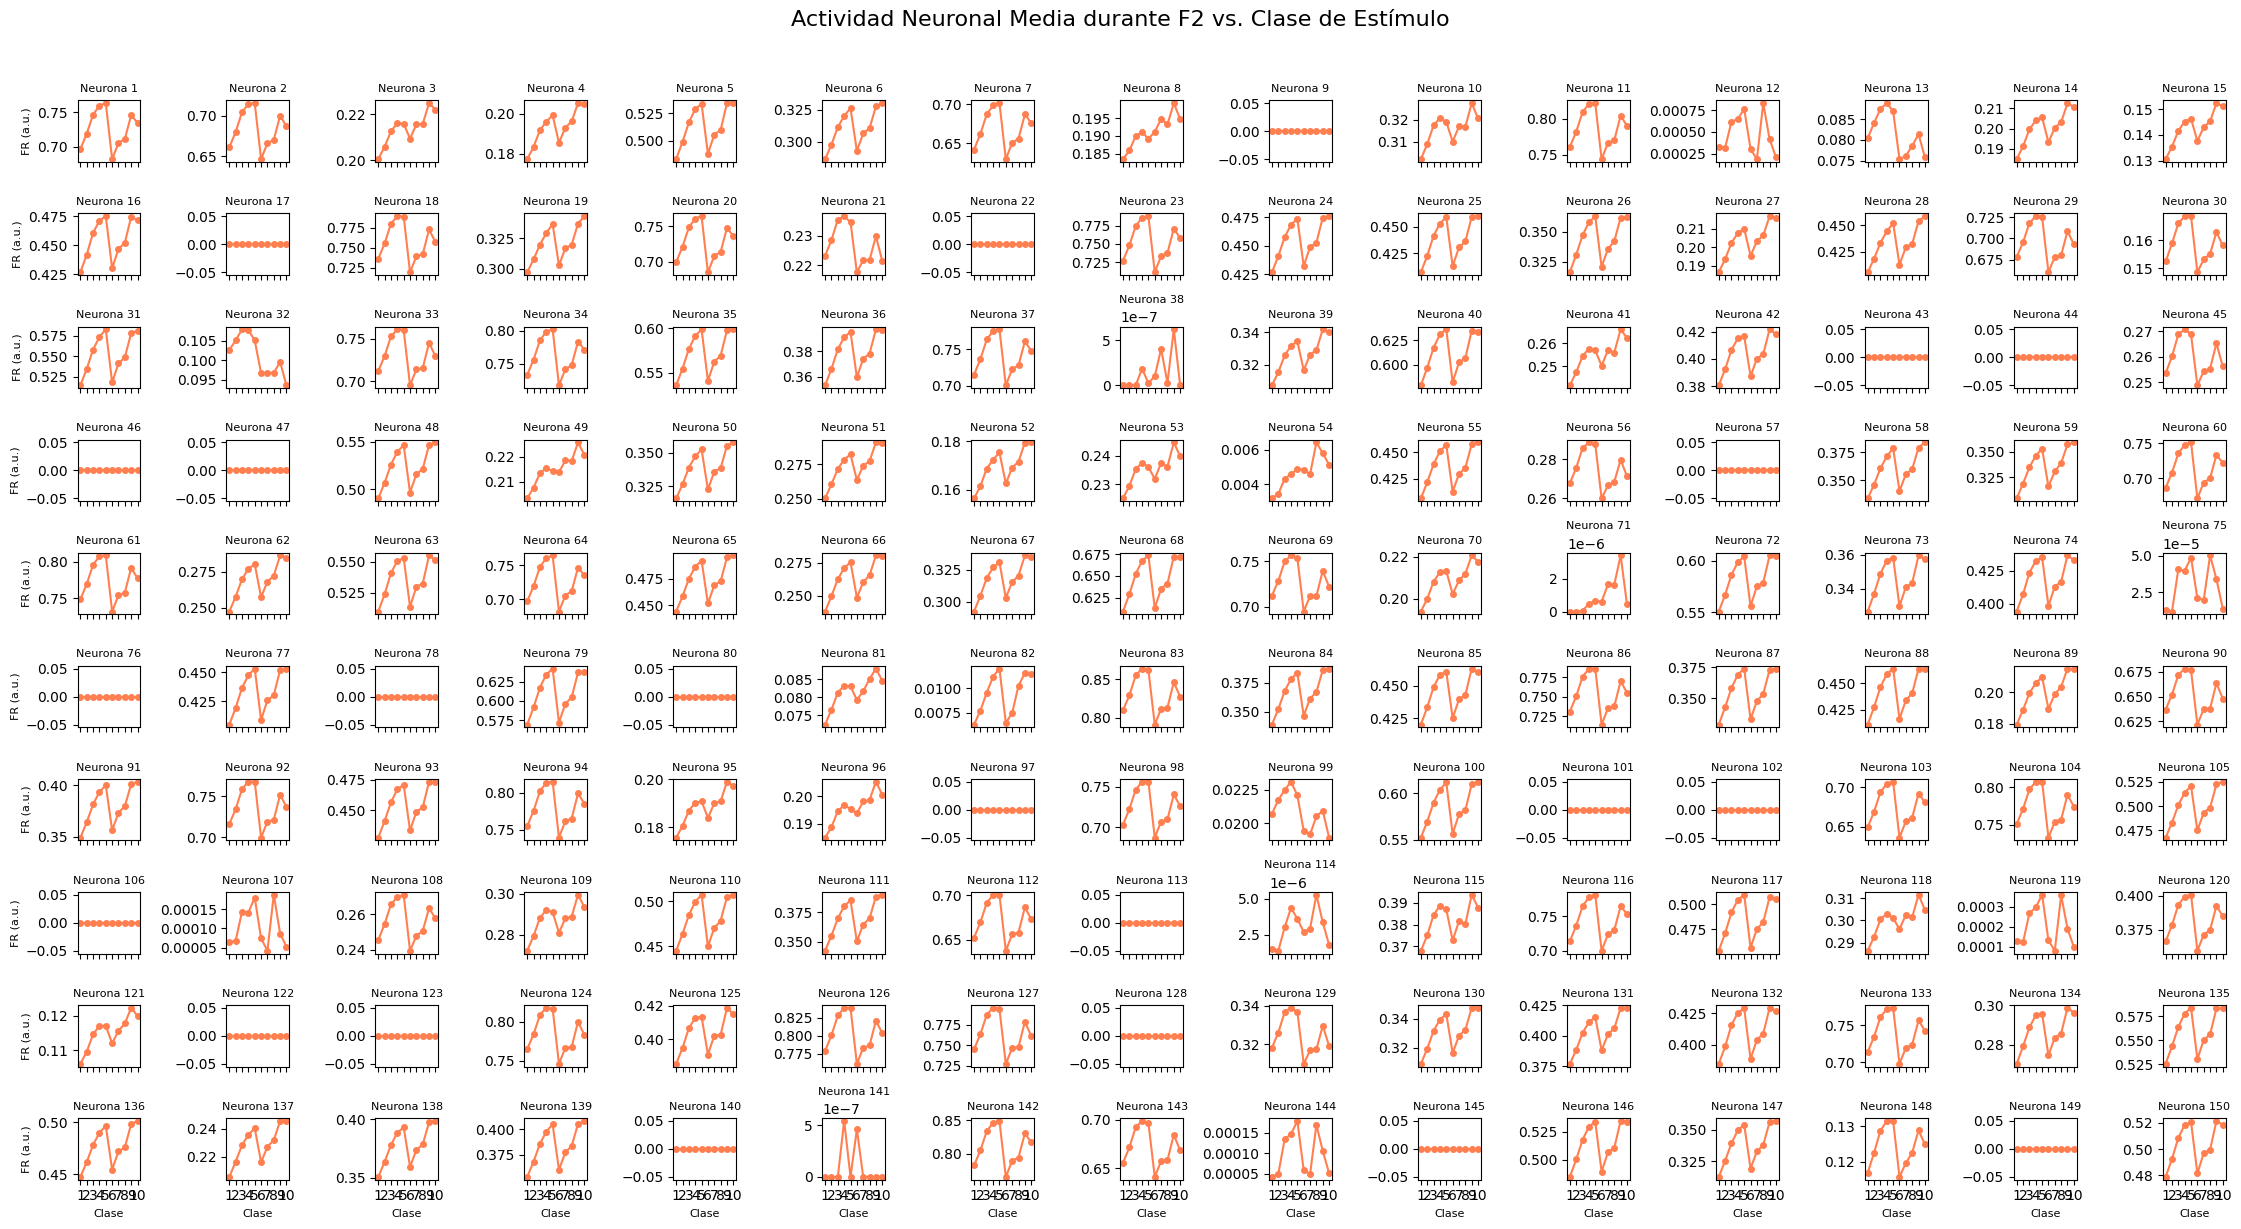


Porcentaje de acierto calculado por condición:
     f1    f2  is_correct  percentage
0  10.0  18.0    0.790865          79
1  14.0  22.0    0.772182          77
2  18.0  10.0    0.240741          24
3  18.0  26.0    0.822126          82
4  22.0  14.0    0.216092          21
5  22.0  30.0    0.772009          77
6  26.0  18.0    0.231325          23
7  26.0  34.0    0.774038          77
8  30.0  22.0    0.213568          21
9  34.0  26.0    0.186398          18


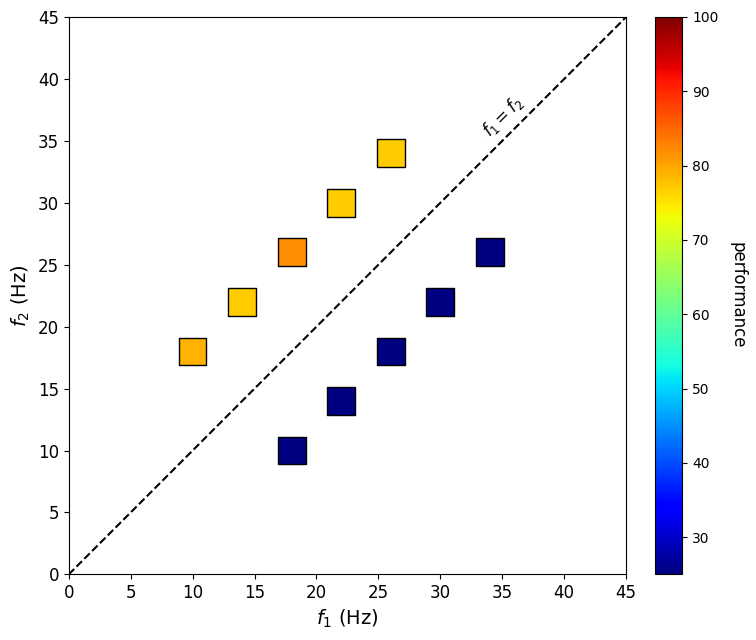


Rendimiento por Número de Clase:
   class_number      mean       sem  mean_perc  sem_perc
0             1  0.774038  0.020529  77.403846  2.052932
1             2  0.772009  0.019955  77.200903  1.995533
2             3  0.822126  0.017830  82.212581  1.782981
3             4  0.772182  0.020564  77.218225  2.056397
4             5  0.790865  0.019964  79.086538  1.996366
5             6  0.186398  0.019569  18.639798  1.956947
6             7  0.213568  0.020569  21.356784  2.056853
7             8  0.231325  0.020724  23.132530  2.072443
8             9  0.216092  0.019756  21.609195  1.975636
9            10  0.240741  0.020594  24.074074  2.059355


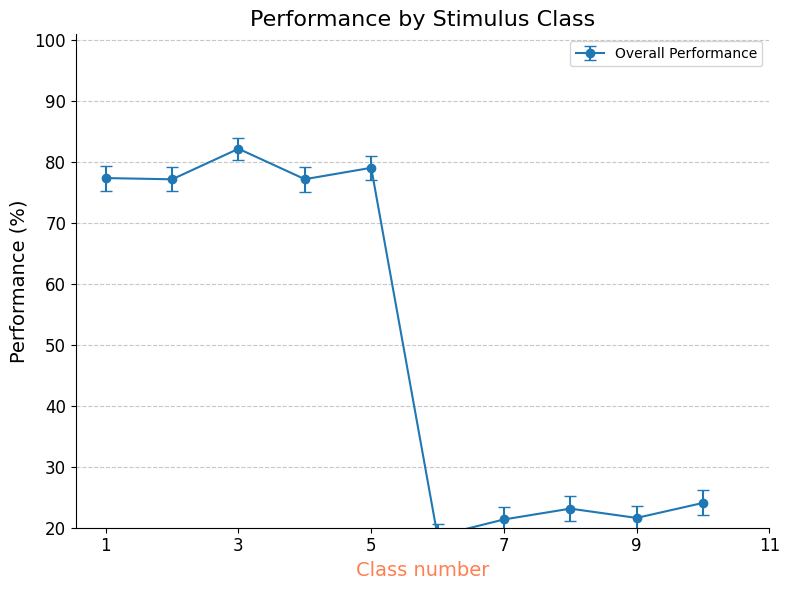

In [ ]:
config = {
        "dt": 10,
        "reward_correct": 1.0,
        "reward_incorrect": 0.0,
        "reward_aborted": -1.0,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.1,
        "reward_decide_fixation": -0.1,
        "duration_params": [10, 10, 10, 10, 10, 10], 
        "actor_hidden_size": 150,
        "critic_hidden_size": 150,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        "print_interval": 100,
        "record_history": True
    }

# --- Cargar resultados para análisis ---
output_dir = Path.cwd() / "outputs"
output_file = output_dir / "WM+_F_rnn.pkl"

print(f"\nLoading results from {output_file} for plotting...")
with open(output_file, "rb") as f:
    (
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        actor_firing_rates,
        critic_firing_rates,
        other_measurements
    ) = pickle.load(f)

# --- Determinar los timesteps para F1 y F2 a partir de la configuración ---
dt = config["dt"]
duration_params = config["duration_params"]

# Convertir duraciones en ms a pasos de tiempo
def _ms_to_steps(ms, dt):
    return max(1, int(round(ms / dt))) if ms > 0 else 0

t_fix_steps = _ms_to_steps(duration_params[0], dt)
t_f1_steps = _ms_to_steps(duration_params[2], dt)
t_delay_steps = _ms_to_steps(duration_params[3], dt)

# El estímulo F1 ocurre después del período de fijación.
f1_start_step = t_fix_steps
f1_end_step = f1_start_step + t_f1_steps
f1_timesteps = range(f1_start_step, f1_end_step)

# El estímulo F2 ocurre después de F1 y el delay.
f2_start_step = f1_end_step + t_delay_steps
f2_end_step = f2_start_step + _ms_to_steps(duration_params[4], dt)
f2_timesteps = range(f2_start_step, f2_end_step)

print(f"Timesteps para F1: {list(f1_timesteps)}")
print(f"Timesteps para F2: {list(f2_timesteps)}")

# --- Llamar a la nueva función de visualización ---
print("\nPlotting neural activity by stimulus class...")
if actor_firing_rates is not None:
    plot_activity_by_stimulus_class(
        all_measurements=other_measurements,
        firing_rates=actor_firing_rates,
        f1_timesteps=f1_timesteps,
        f2_timesteps=f2_timesteps,
        n_rows=10,
        n_cols=15
    )
else:
    print("No se encontraron datos de actividad del actor para graficar.")

plot_performance_matrix(other_measurements)

sesgo_contraccion(other_measurements)

### STEP 2


Loading results from /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/outputs/WM+_F_rnn_2.pkl for plotting...
Timesteps para F1: [1]
Timesteps para F2: [3]

Plotting neural activity by stimulus class...


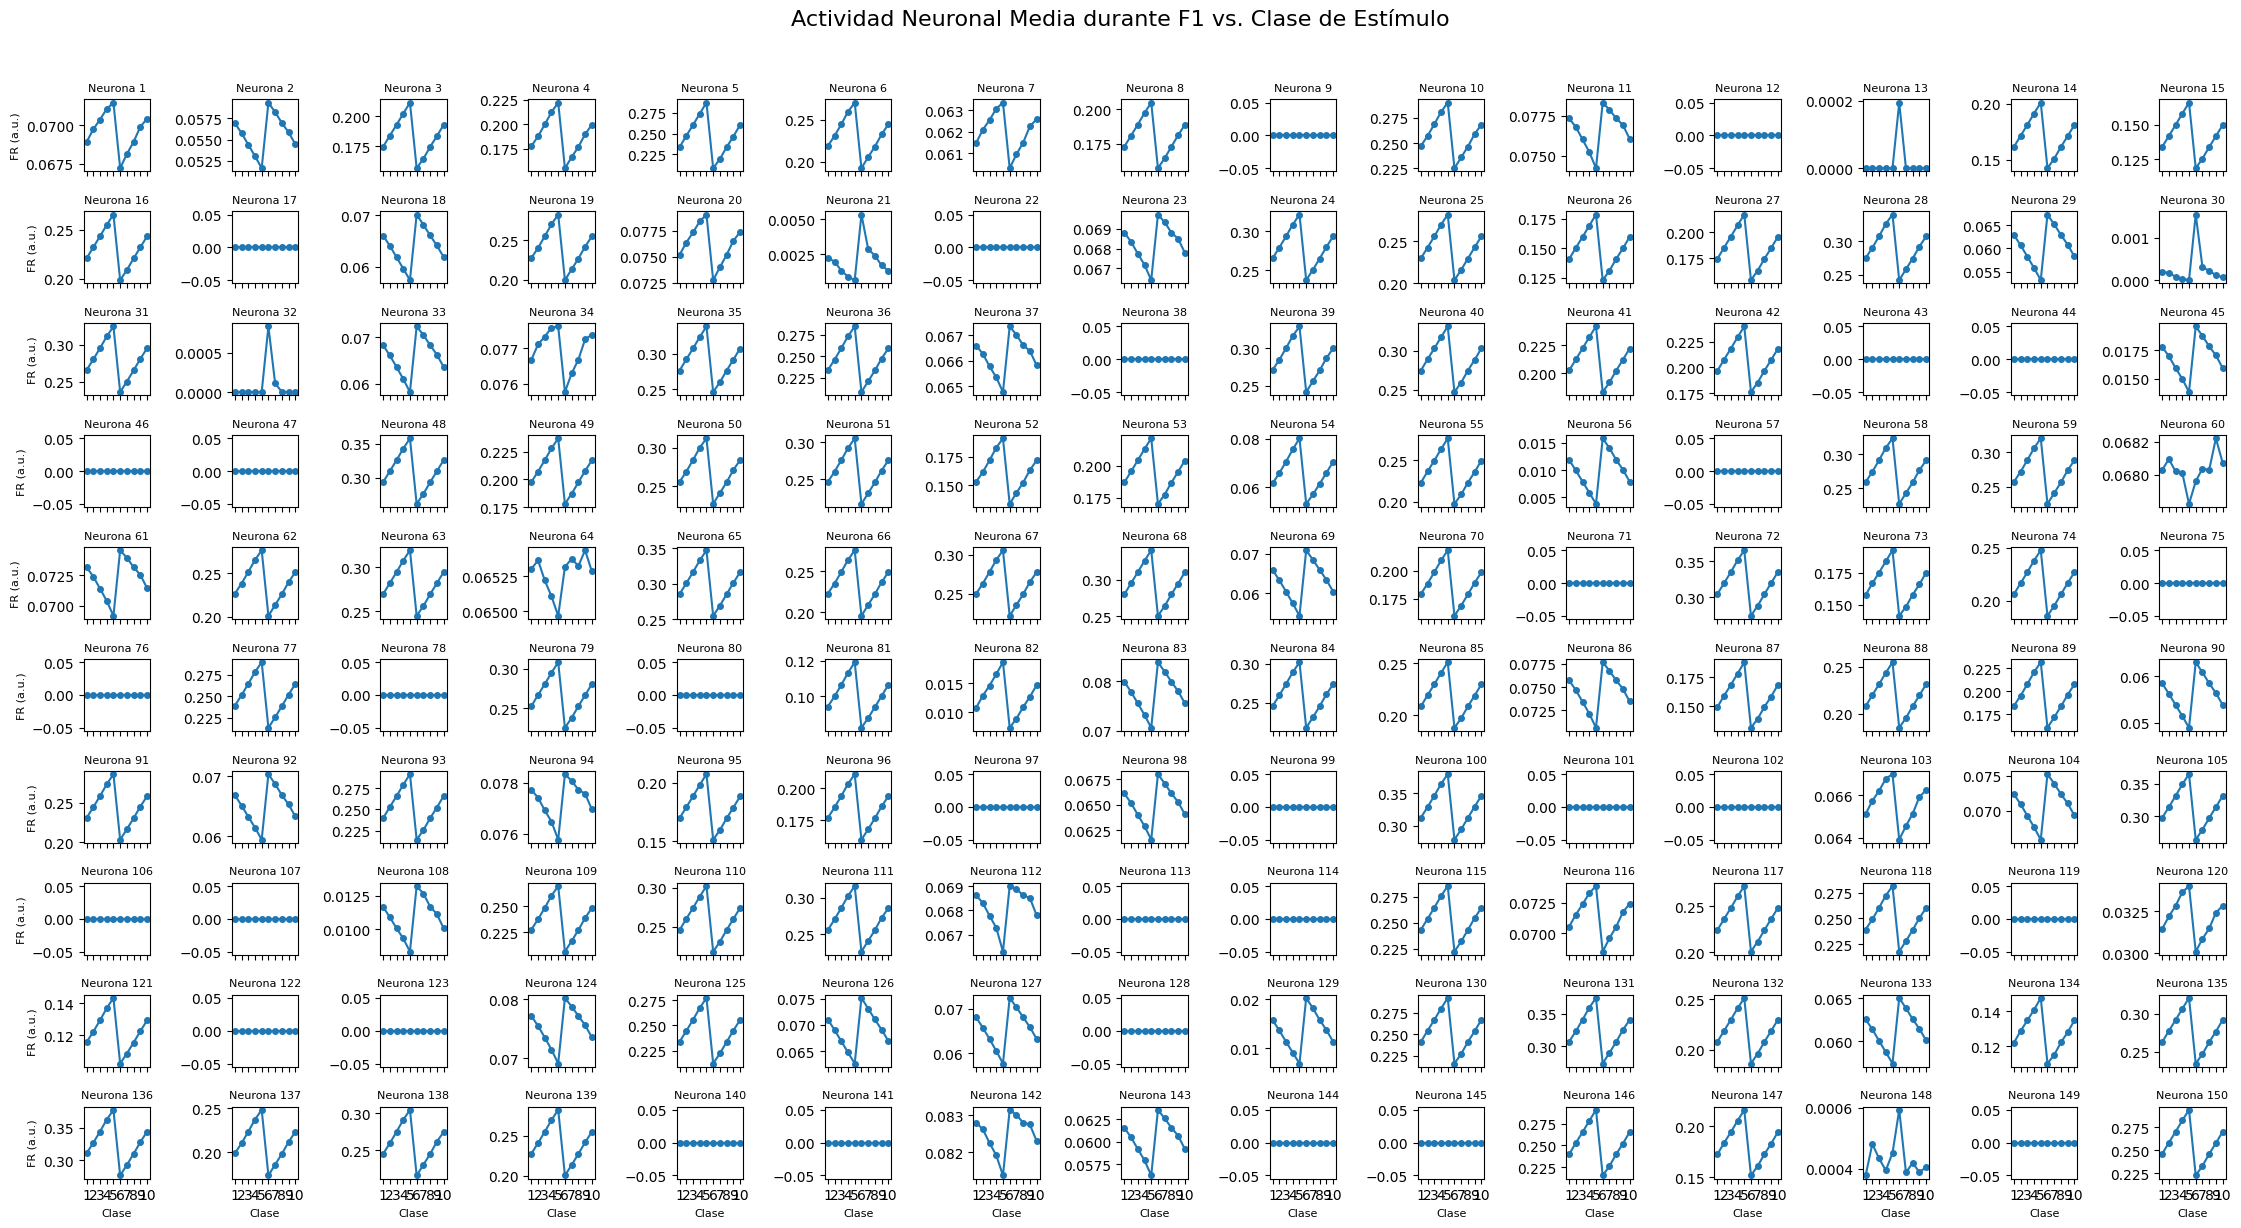

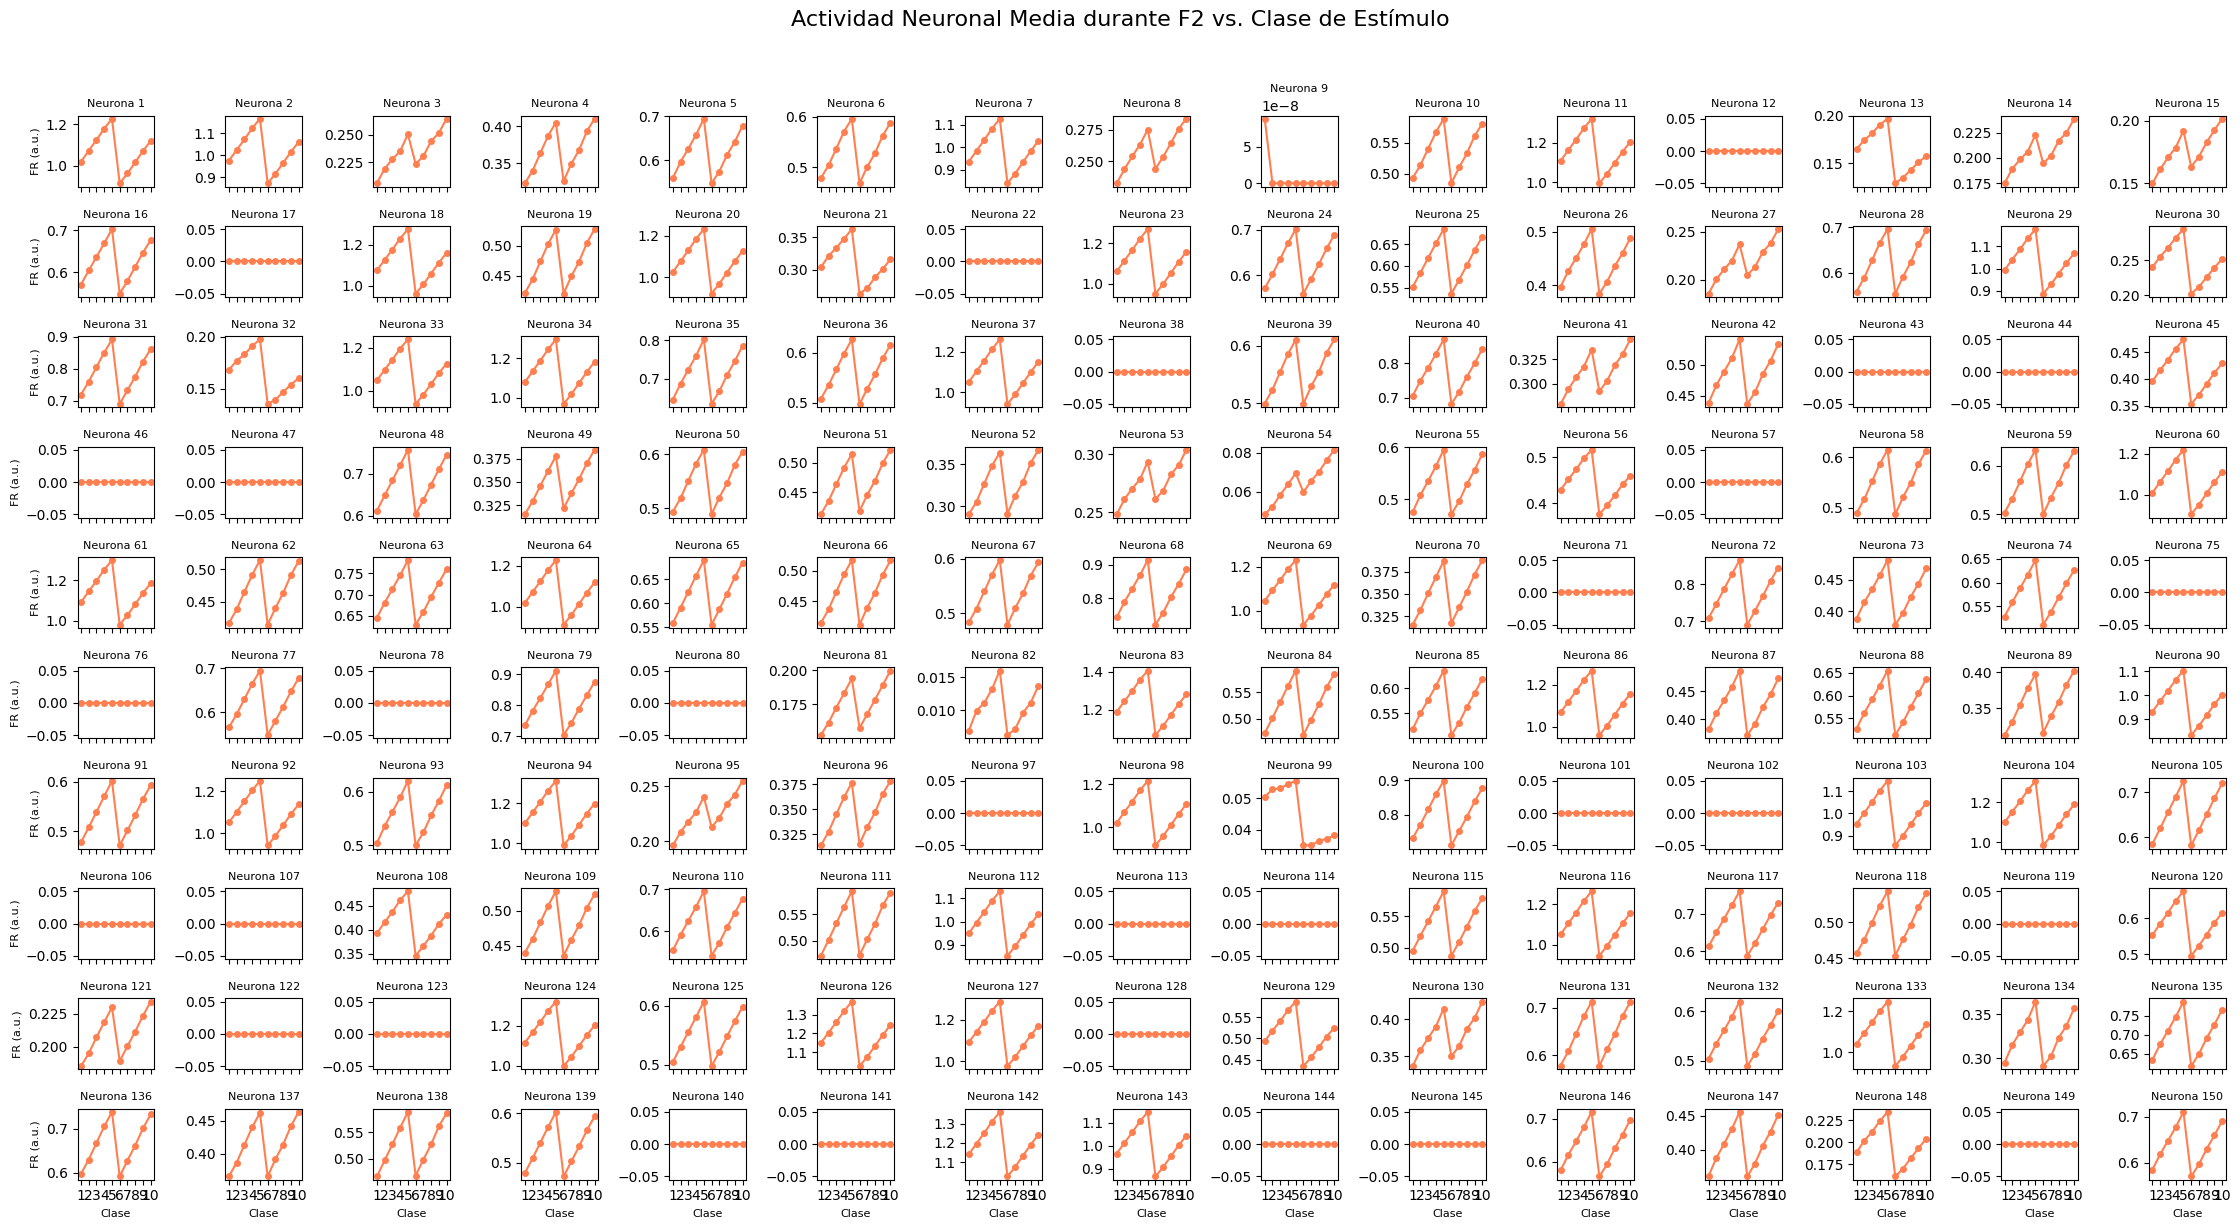


Porcentaje de acierto calculado por condición:
     f1    f2  is_correct  percentage
0  10.0  18.0    0.693899          69
1  14.0  22.0    0.660679          66
2  18.0  10.0    0.479873          48
3  18.0  26.0    0.683369          68
4  22.0  14.0    0.467358          46
5  22.0  30.0    0.658228          65
6  26.0  18.0    0.474490          47
7  26.0  34.0    0.647716          64
8  30.0  22.0    0.484440          48
9  34.0  26.0    0.471338          47


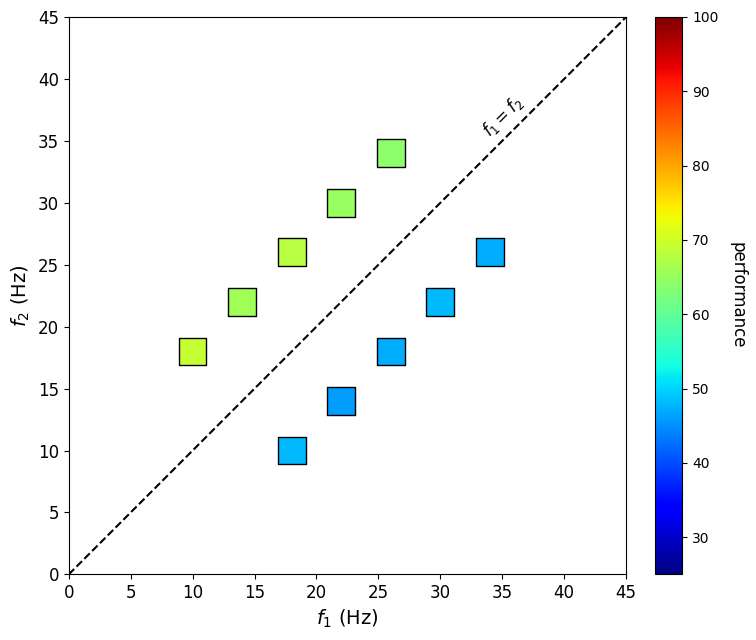


Rendimiento por Número de Clase:
   class_number      mean       sem  mean_perc  sem_perc
0             1  0.647716  0.015228  64.771574  1.522794
1             2  0.658228  0.015413  65.822785  1.541280
2             3  0.683369  0.015196  68.336887  1.519619
3             4  0.660679  0.014965  66.067864  1.496524
4             5  0.693899  0.014828  69.389866  1.482832
5             6  0.471338  0.016273  47.133758  1.627273
6             7  0.484440  0.016104  48.443983  1.610447
7             8  0.474490  0.015959  47.448980  1.595926
8             9  0.467358  0.016070  46.735751  1.606956
9            10  0.479873  0.016269  47.987288  1.626904


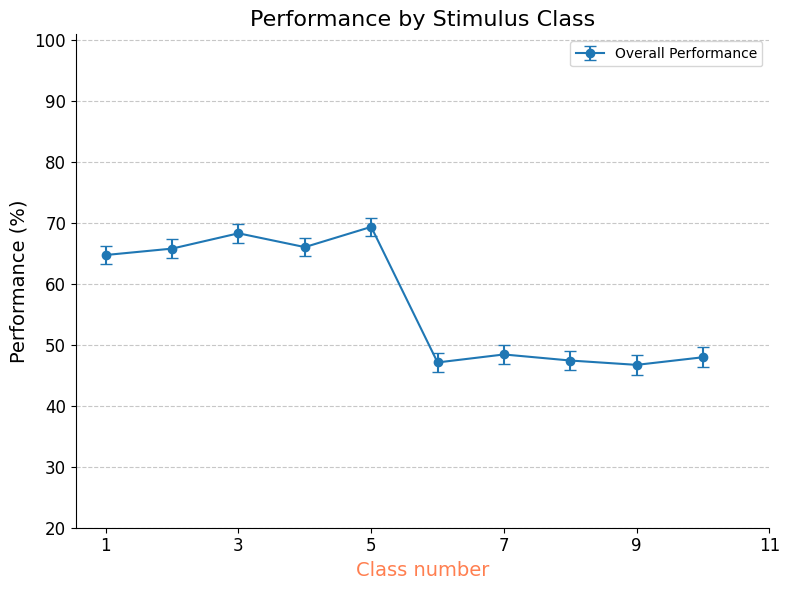

In [ ]:
config = {
        "dt": 10,
        "reward_correct": 1.0,
        "reward_incorrect": 0.0,
        "reward_aborted": -1.0,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.1,
        "reward_decide_fixation": -0.1,
        "duration_params": [10, 10, 10, 10, 10, 10], 
        "actor_hidden_size": 150,
        "critic_hidden_size": 150,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        "print_interval": 100,
        "record_history": True
    }

# --- Cargar resultados para análisis ---
output_dir = Path.cwd() / "outputs"
output_file = output_dir / "WM+_F_rnn_2.pkl"

print(f"\nLoading results from {output_file} for plotting...")
with open(output_file, "rb") as f:
    (
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        actor_firing_rates,
        critic_firing_rates,
        other_measurements
    ) = pickle.load(f)

# --- Determinar los timesteps para F1 y F2 a partir de la configuración ---
dt = config["dt"]
duration_params = config["duration_params"]

# Convertir duraciones en ms a pasos de tiempo
def _ms_to_steps(ms, dt):
    return max(1, int(round(ms / dt))) if ms > 0 else 0

t_fix_steps = _ms_to_steps(duration_params[0], dt)
t_f1_steps = _ms_to_steps(duration_params[2], dt)
t_delay_steps = _ms_to_steps(duration_params[3], dt)

# El estímulo F1 ocurre después del período de fijación.
f1_start_step = t_fix_steps
f1_end_step = f1_start_step + t_f1_steps
f1_timesteps = range(f1_start_step, f1_end_step)

# El estímulo F2 ocurre después de F1 y el delay.
f2_start_step = f1_end_step + t_delay_steps
f2_end_step = f2_start_step + _ms_to_steps(duration_params[4], dt)
f2_timesteps = range(f2_start_step, f2_end_step)

print(f"Timesteps para F1: {list(f1_timesteps)}")
print(f"Timesteps para F2: {list(f2_timesteps)}")

# --- Llamar a la nueva función de visualización ---
print("\nPlotting neural activity by stimulus class...")
if actor_firing_rates is not None:
    plot_activity_by_stimulus_class(
        all_measurements=other_measurements,
        firing_rates=actor_firing_rates,
        f1_timesteps=f1_timesteps,
        f2_timesteps=f2_timesteps,
        n_rows=10,
        n_cols=15
    )
else:
    print("No se encontraron datos de actividad del actor para graficar.")

plot_performance_matrix(other_measurements)

sesgo_contraccion(other_measurements)

### STEP 3


Loading results from /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/outputs/WM+_F_rnn_3.pkl for plotting...
Timesteps para F1: [1]
Timesteps para F2: [3]

Plotting neural activity by stimulus class...


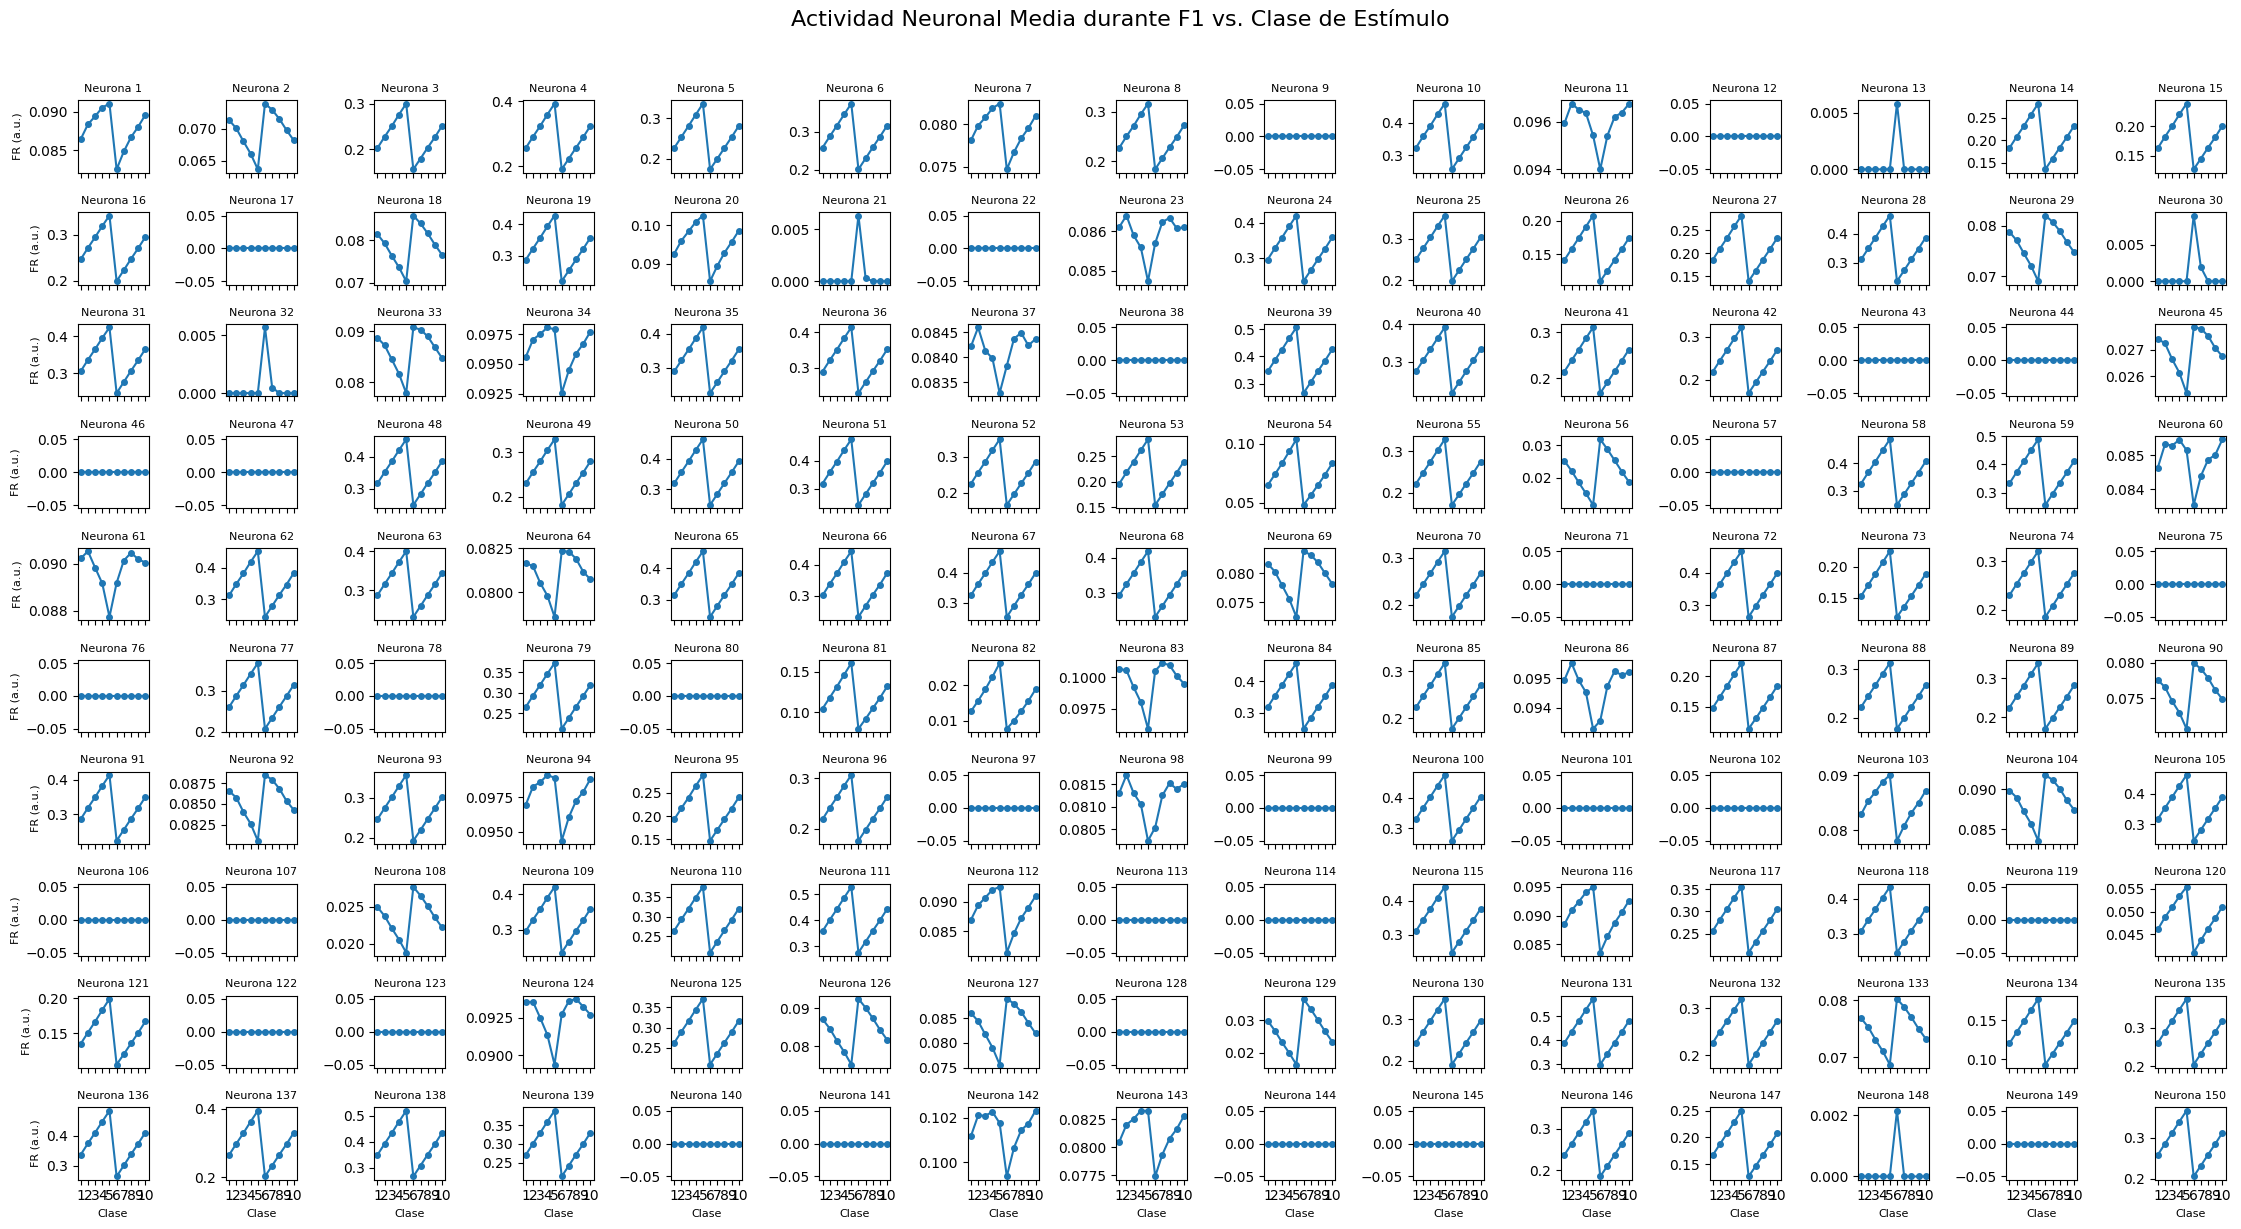

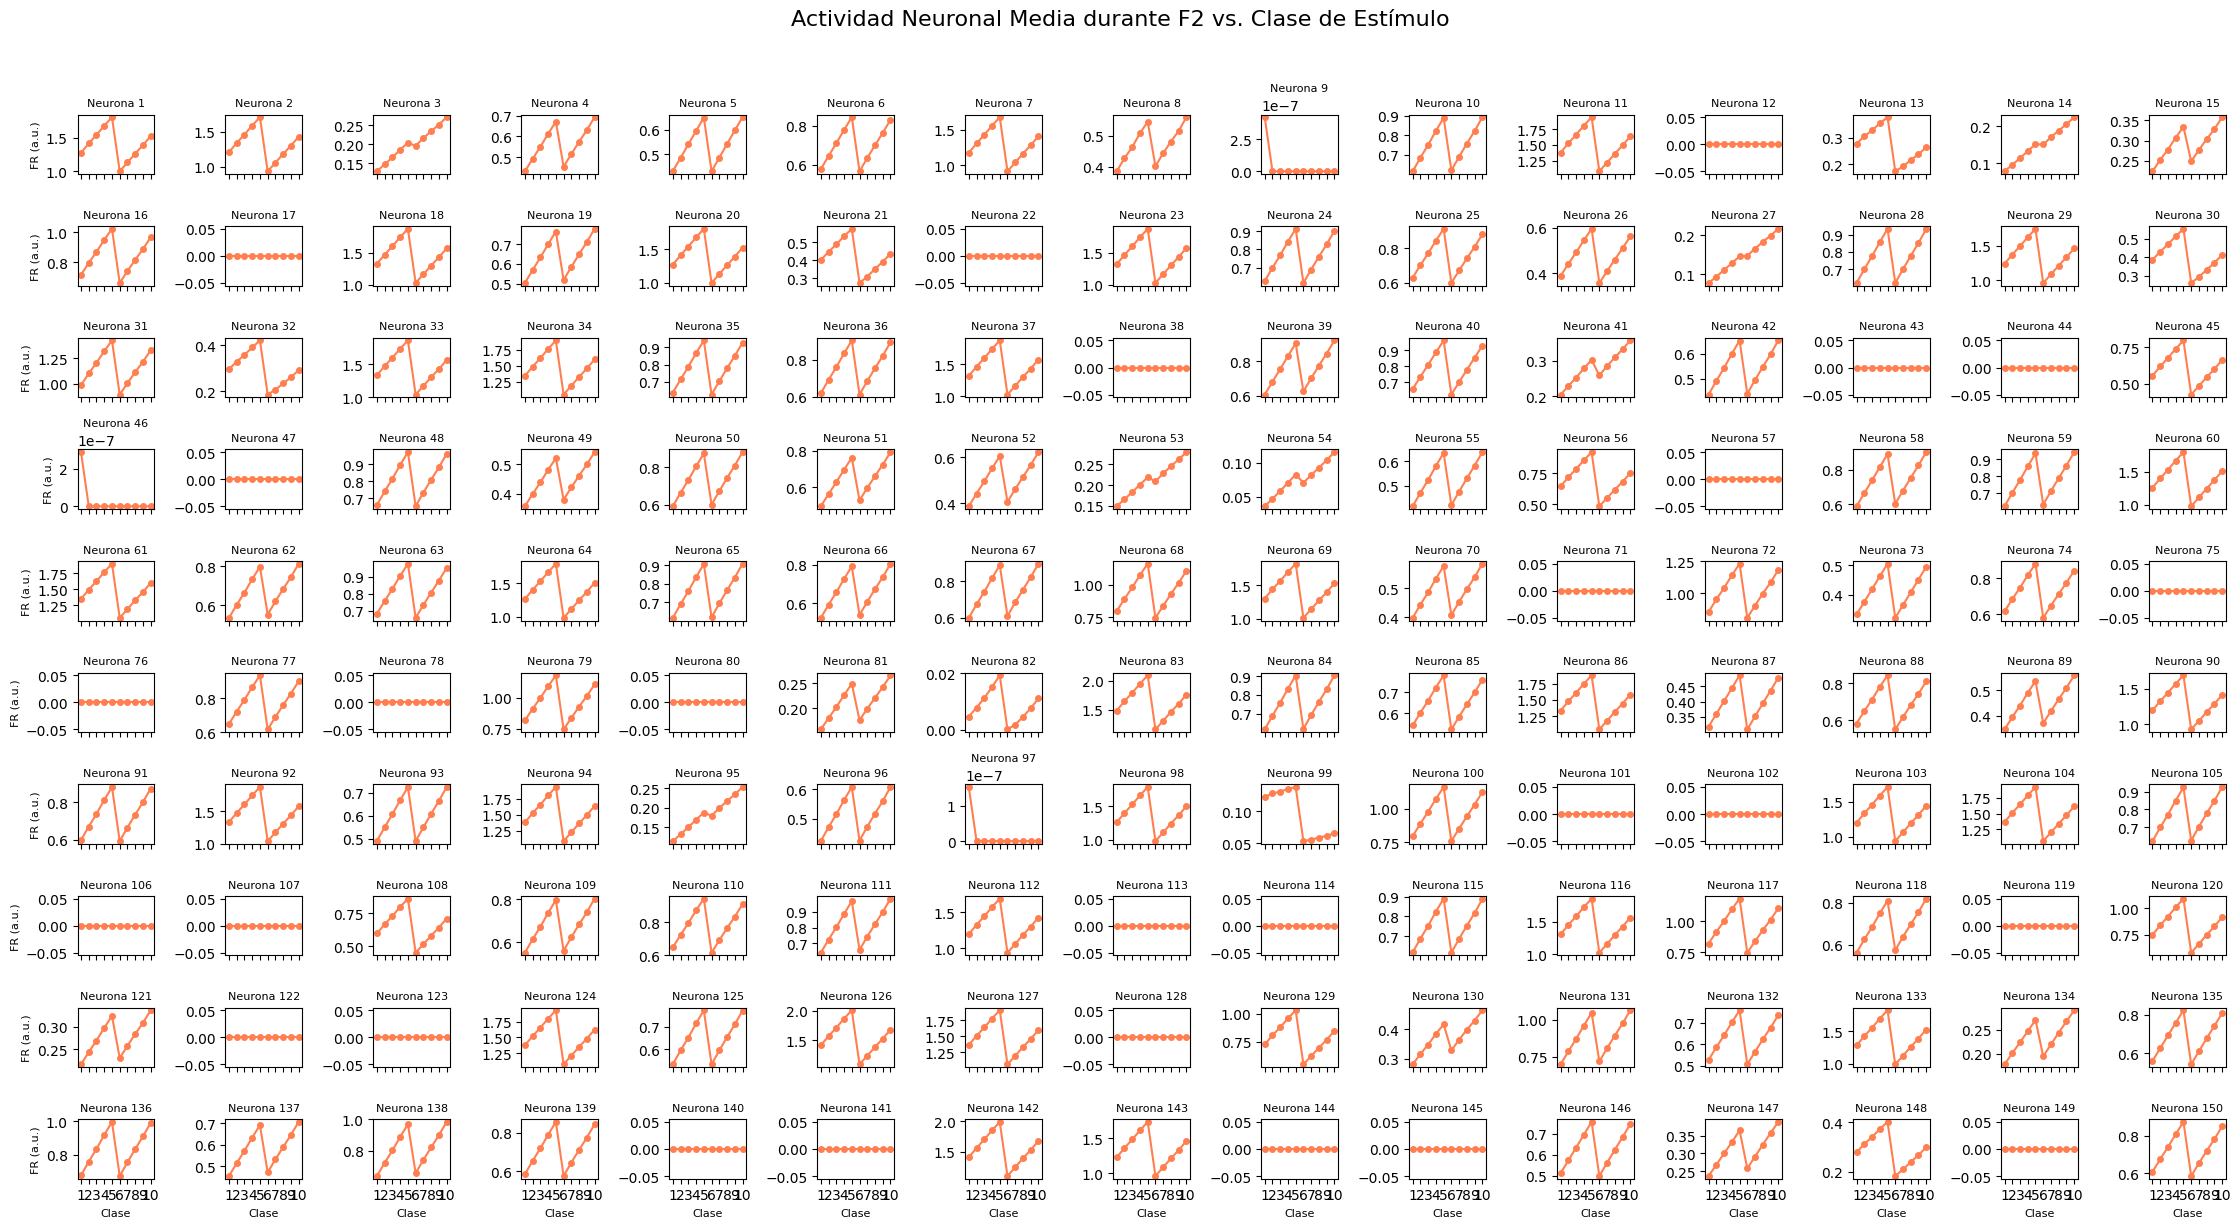


Porcentaje de acierto calculado por condición:
     f1    f2  is_correct  percentage
0  10.0  18.0    0.926882          92
1  14.0  22.0    0.907150          90
2  18.0  10.0    0.864754          86
3  18.0  26.0    0.905274          90
4  22.0  14.0    0.903427          90
5  22.0  30.0    0.872188          87
6  26.0  18.0    0.906929          90
7  26.0  34.0    0.856704          85
8  30.0  22.0    0.910526          91
9  34.0  26.0    0.918570          91


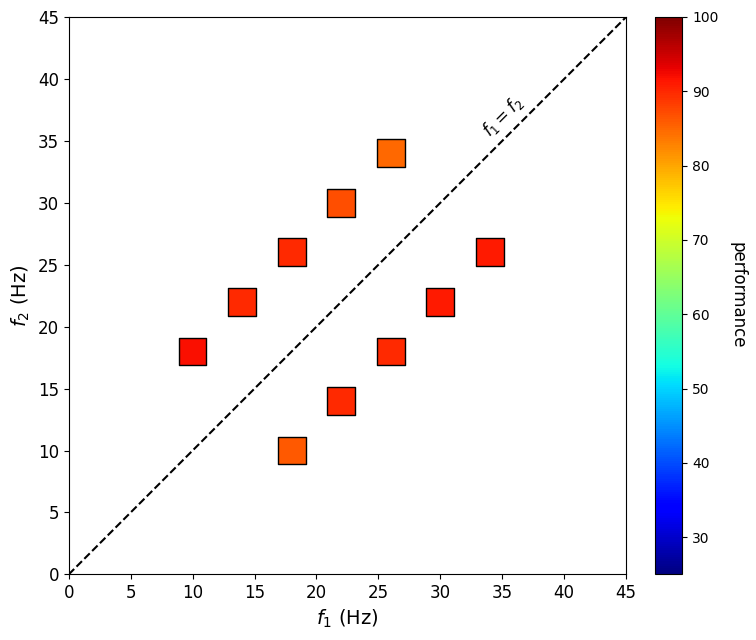


Rendimiento por Número de Clase:
   class_number      mean       sem  mean_perc  sem_perc
0             1  0.856704  0.011215  85.670420  1.121521
1             2  0.872188  0.010682  87.218814  1.068177
2             3  0.905274  0.009613  90.527449  0.961279
3             4  0.907150  0.009486  90.715048  0.948618
4             5  0.926882  0.008541  92.688172  0.854117
5             6  0.918570  0.008623  91.857001  0.862282
6             7  0.910526  0.009265  91.052632  0.926533
7             8  0.906929  0.009348  90.692865  0.934773
8             9  0.903427  0.009523  90.342679  0.952330
9            10  0.864754  0.010952  86.475410  1.095232


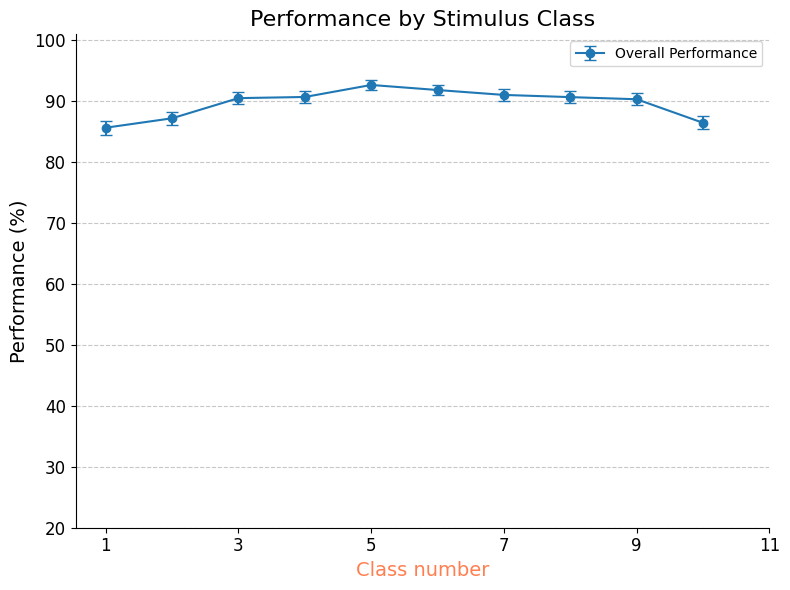

In [ ]:
config = {
        "dt": 10,
        "reward_correct": 1.0,
        "reward_incorrect": 0.0,
        "reward_aborted": -1.0,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.1,
        "reward_decide_fixation": -0.1,
        "duration_params": [10, 10, 10, 10, 10, 10], 
        "actor_hidden_size": 150,
        "critic_hidden_size": 150,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        "print_interval": 100,
        "record_history": True
    }

# --- Cargar resultados para análisis ---
output_dir = Path.cwd() / "outputs"
output_file = output_dir / "WM+_F_rnn_3.pkl"

print(f"\nLoading results from {output_file} for plotting...")
with open(output_file, "rb") as f:
    (
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        actor_firing_rates,
        critic_firing_rates,
        other_measurements
    ) = pickle.load(f)

# --- Determinar los timesteps para F1 y F2 a partir de la configuración ---
dt = config["dt"]
duration_params = config["duration_params"]

# Convertir duraciones en ms a pasos de tiempo
def _ms_to_steps(ms, dt):
    return max(1, int(round(ms / dt))) if ms > 0 else 0

t_fix_steps = _ms_to_steps(duration_params[0], dt)
t_f1_steps = _ms_to_steps(duration_params[2], dt)
t_delay_steps = _ms_to_steps(duration_params[3], dt)

# El estímulo F1 ocurre después del período de fijación.
f1_start_step = t_fix_steps
f1_end_step = f1_start_step + t_f1_steps
f1_timesteps = range(f1_start_step, f1_end_step)

# El estímulo F2 ocurre después de F1 y el delay.
f2_start_step = f1_end_step + t_delay_steps
f2_end_step = f2_start_step + _ms_to_steps(duration_params[4], dt)
f2_timesteps = range(f2_start_step, f2_end_step)

print(f"Timesteps para F1: {list(f1_timesteps)}")
print(f"Timesteps para F2: {list(f2_timesteps)}")

# --- Llamar a la nueva función de visualización ---
print("\nPlotting neural activity by stimulus class...")
if actor_firing_rates is not None:
    plot_activity_by_stimulus_class(
        all_measurements=other_measurements,
        firing_rates=actor_firing_rates,
        f1_timesteps=f1_timesteps,
        f2_timesteps=f2_timesteps,
        n_rows=10,
        n_cols=15
    )
else:
    print("No se encontraron datos de actividad del actor para graficar.")

plot_performance_matrix(other_measurements)

sesgo_contraccion(other_measurements)

### STEP 4


Loading results from /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/outputs/WM+_F_rnn_4.pkl for plotting...
Timesteps para F1: [1]
Timesteps para F2: [3]

Plotting neural activity by stimulus class...


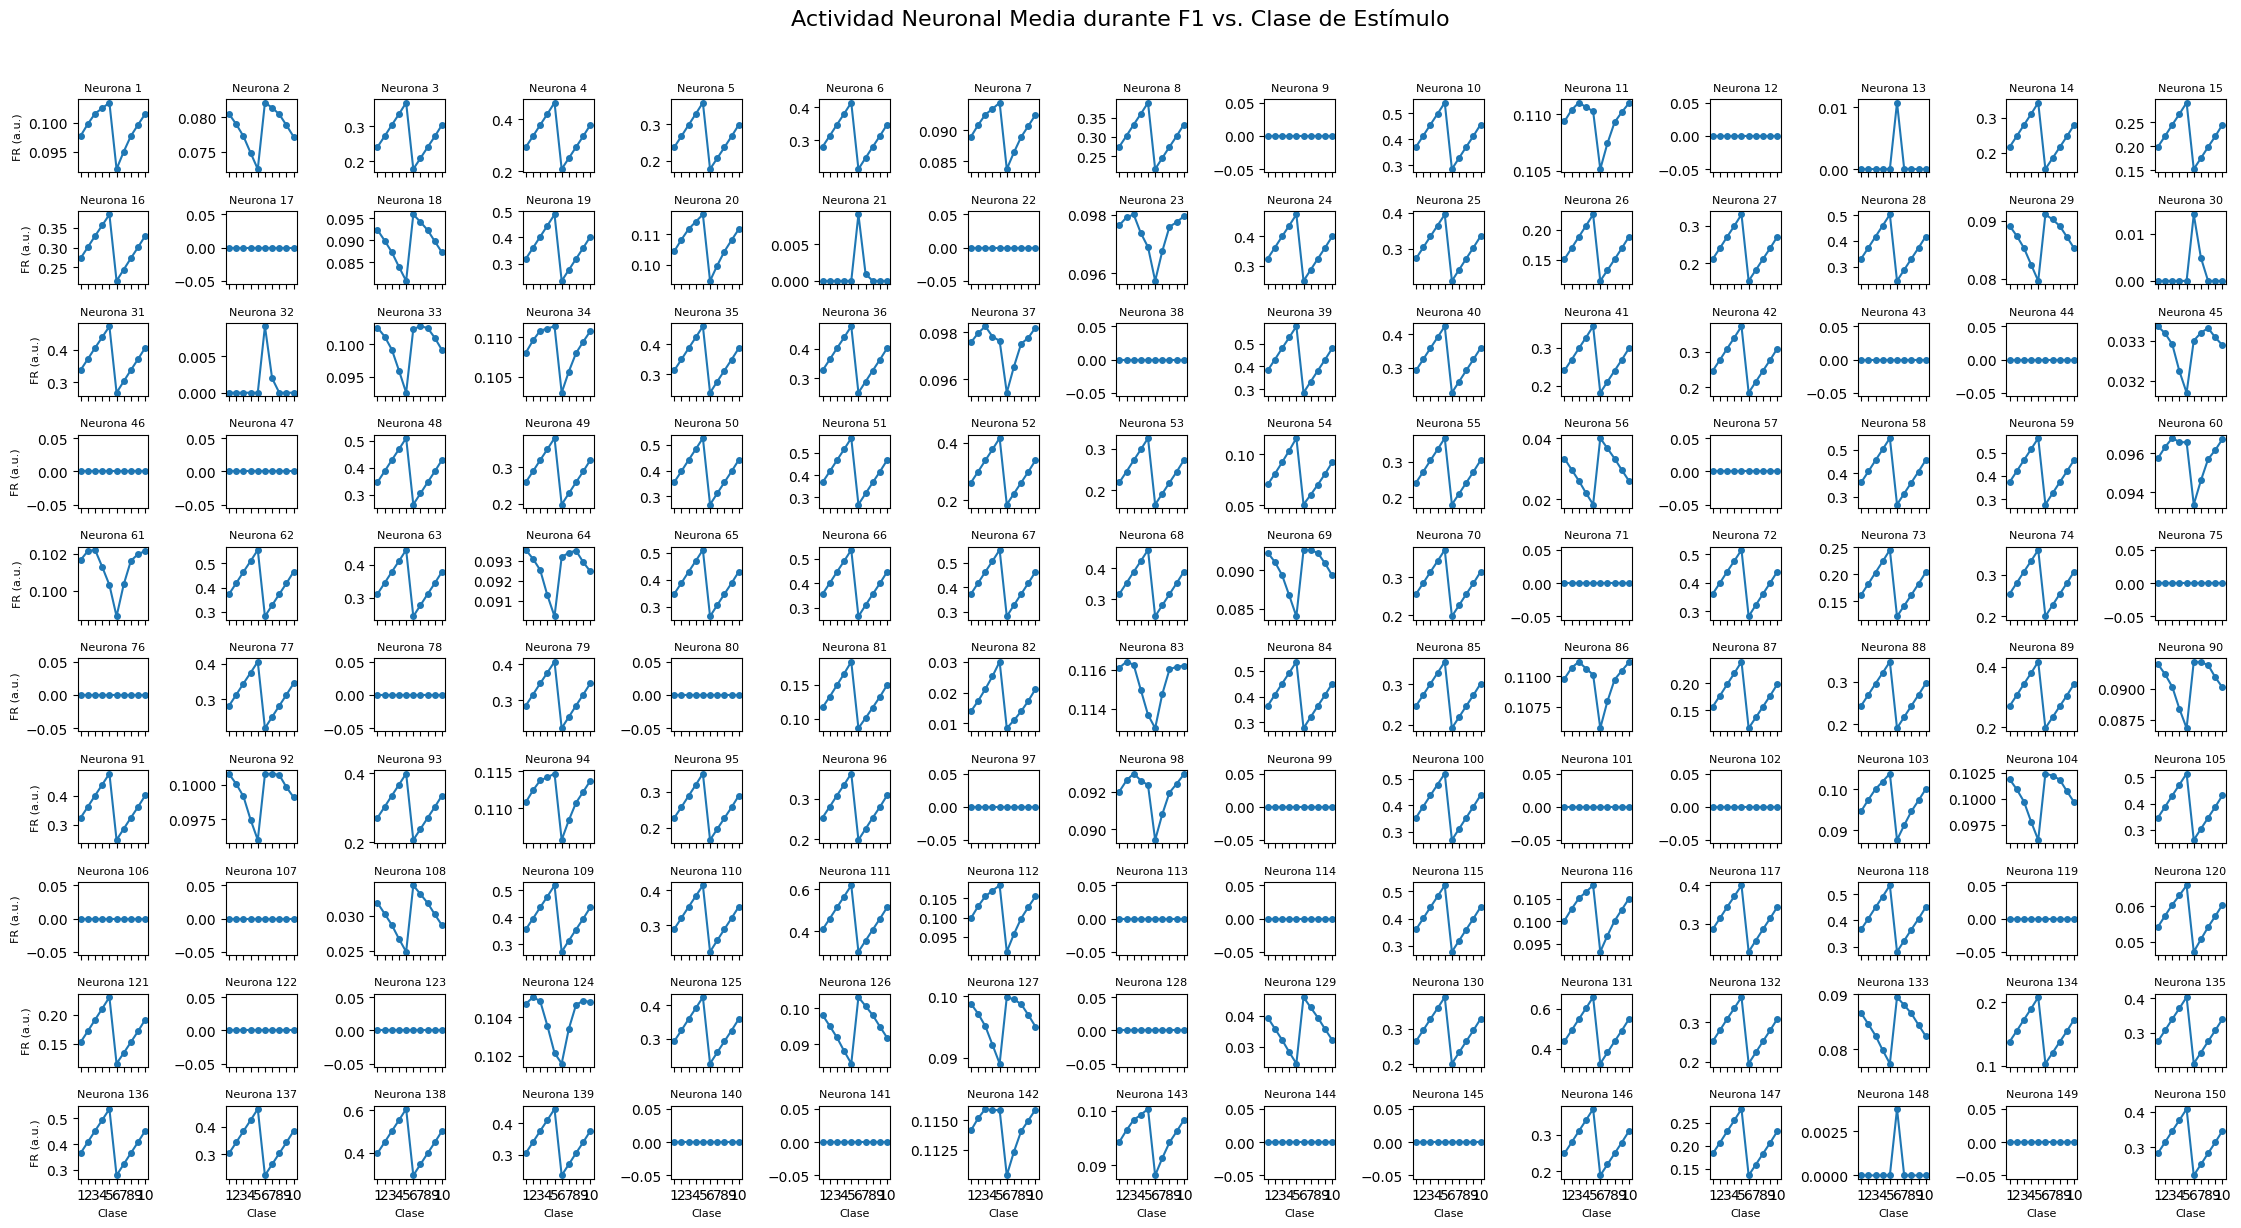

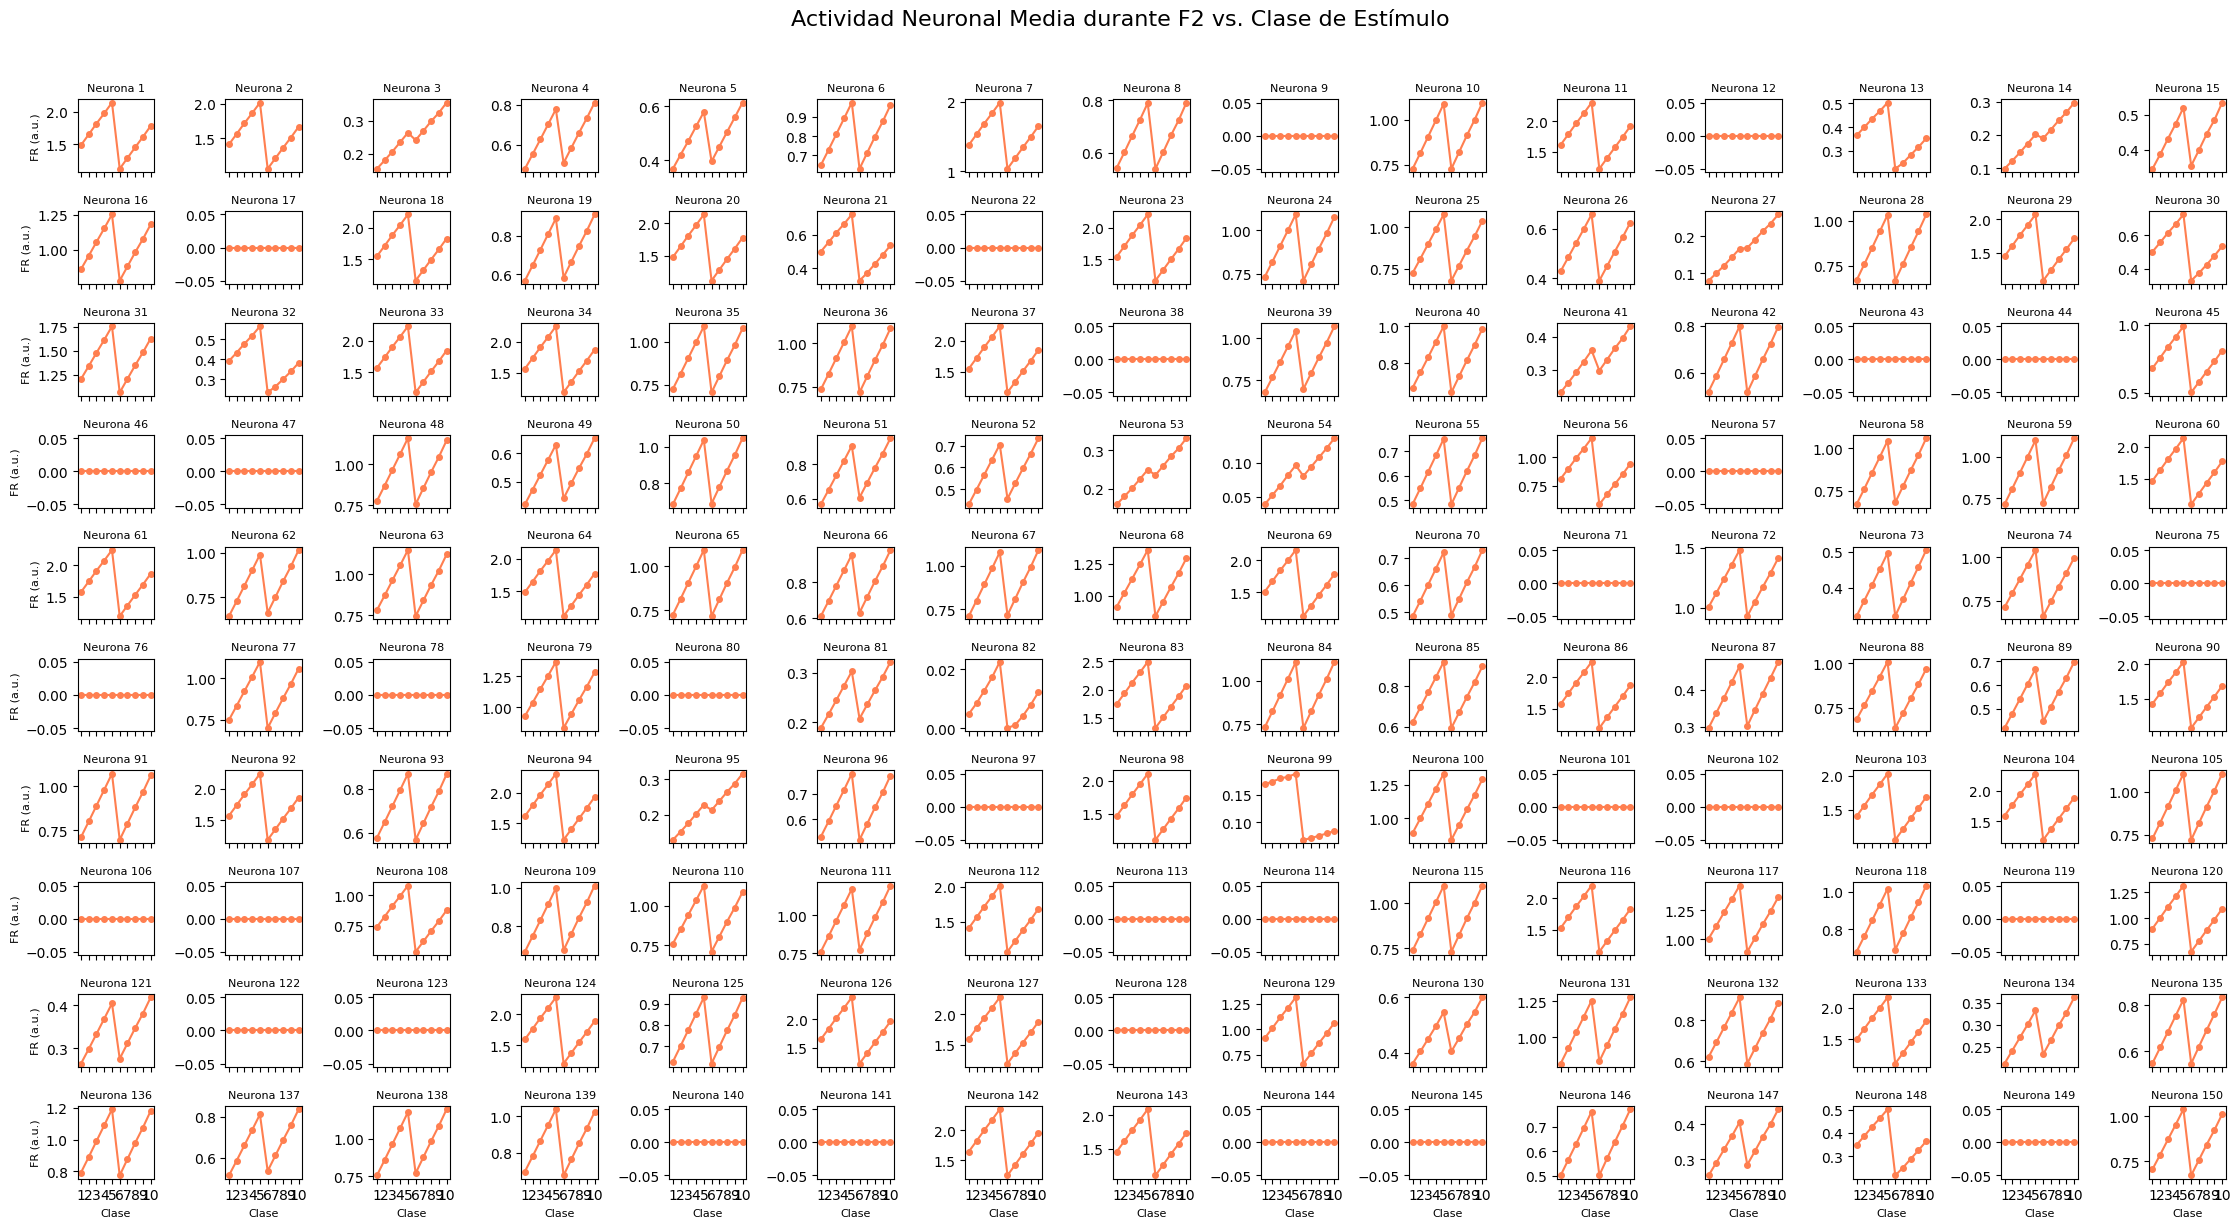


Porcentaje de acierto calculado por condición:
     f1    f2  is_correct  percentage
0  10.0  18.0    0.979167          97
1  14.0  22.0    0.983264          98
2  18.0  10.0    0.978641          97
3  18.0  26.0    0.982063          98
4  22.0  14.0    0.976096          97
5  22.0  30.0    0.978903          97
6  26.0  18.0    0.966443          96
7  26.0  34.0    0.960499          96
8  30.0  22.0    0.988166          98
9  34.0  26.0    0.984221          98


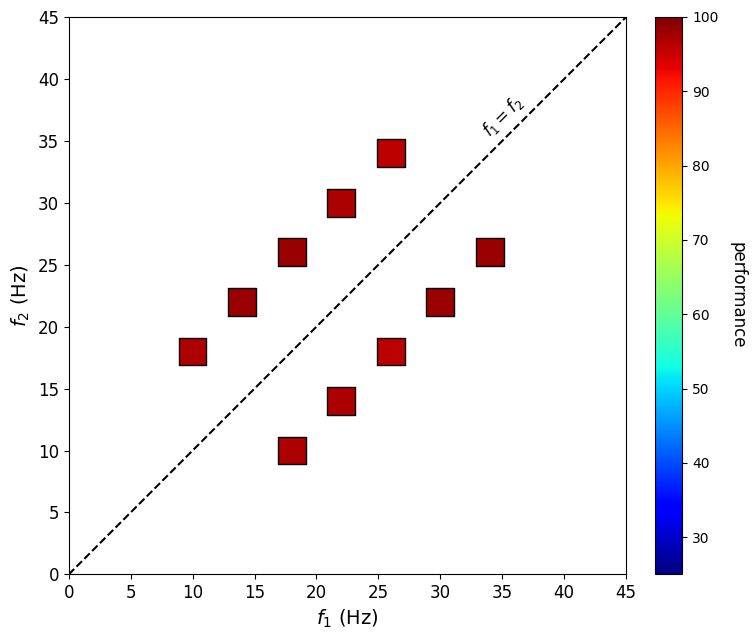


Rendimiento por Número de Clase:
   class_number      mean       sem  mean_perc  sem_perc
0             1  0.960499  0.008891  96.049896  0.889062
1             2  0.978903  0.006608  97.890295  0.660770
2             3  0.982063  0.006292  98.206278  0.629169
3             4  0.983264  0.005874  98.326360  0.587363
4             5  0.979167  0.006526  97.916667  0.652589
5             6  0.984221  0.005540  98.422091  0.554003
6             7  0.988166  0.004807  98.816568  0.480741
7             8  0.966443  0.008527  96.644295  0.852732
8             9  0.976096  0.006824  97.609562  0.682443
9            10  0.978641  0.006377  97.864078  0.637709


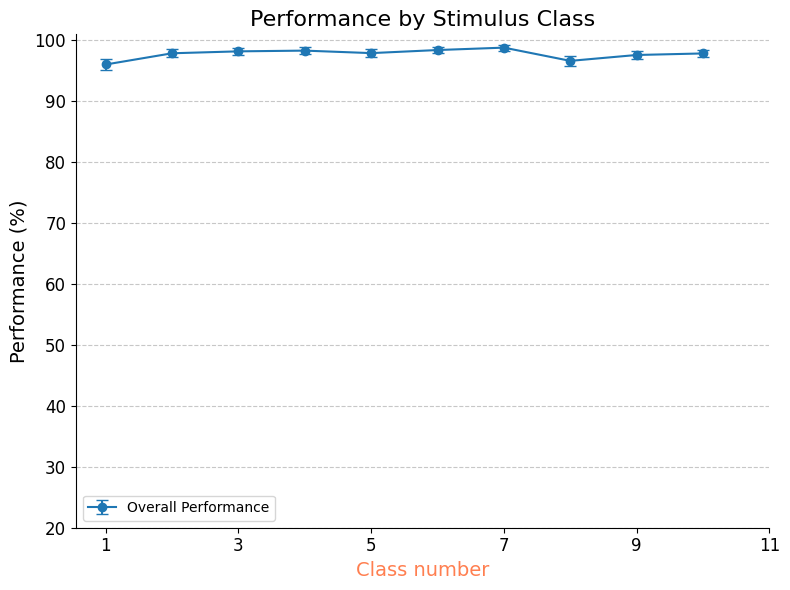

In [ ]:
config = {
        "dt": 10,
        "reward_correct": 1.0,
        "reward_incorrect": 0.0,
        "reward_aborted": -1.0,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.1,
        "reward_decide_fixation": -0.1,
        "duration_params": [10, 10, 10, 10, 10, 10], 
        "actor_hidden_size": 150,
        "critic_hidden_size": 150,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        "print_interval": 100,
        "record_history": True
    }

# --- Cargar resultados para análisis ---
output_dir = Path.cwd() / "outputs"
output_file = output_dir / "WM+_F_rnn_4.pkl"

print(f"\nLoading results from {output_file} for plotting...")
with open(output_file, "rb") as f:
    (
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        actor_firing_rates,
        critic_firing_rates,
        other_measurements
    ) = pickle.load(f)

# --- Determinar los timesteps para F1 y F2 a partir de la configuración ---
dt = config["dt"]
duration_params = config["duration_params"]

# Convertir duraciones en ms a pasos de tiempo
def _ms_to_steps(ms, dt):
    return max(1, int(round(ms / dt))) if ms > 0 else 0

t_fix_steps = _ms_to_steps(duration_params[0], dt)
t_f1_steps = _ms_to_steps(duration_params[2], dt)
t_delay_steps = _ms_to_steps(duration_params[3], dt)

# El estímulo F1 ocurre después del período de fijación.
f1_start_step = t_fix_steps
f1_end_step = f1_start_step + t_f1_steps
f1_timesteps = range(f1_start_step, f1_end_step)

# El estímulo F2 ocurre después de F1 y el delay.
f2_start_step = f1_end_step + t_delay_steps
f2_end_step = f2_start_step + _ms_to_steps(duration_params[4], dt)
f2_timesteps = range(f2_start_step, f2_end_step)

print(f"Timesteps para F1: {list(f1_timesteps)}")
print(f"Timesteps para F2: {list(f2_timesteps)}")

# --- Llamar a la nueva función de visualización ---
print("\nPlotting neural activity by stimulus class...")
if actor_firing_rates is not None:
    plot_activity_by_stimulus_class(
        all_measurements=other_measurements,
        firing_rates=actor_firing_rates,
        f1_timesteps=f1_timesteps,
        f2_timesteps=f2_timesteps,
        n_rows=10,
        n_cols=15
    )
else:
    print("No se encontraron datos de actividad del actor para graficar.")

plot_performance_matrix(other_measurements)

sesgo_contraccion(other_measurements)

### STEP 5


Loading results from /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/outputs/WM+_F_rnn_5.pkl for plotting...
Timesteps para F1: [1]
Timesteps para F2: [3]

Plotting neural activity by stimulus class...


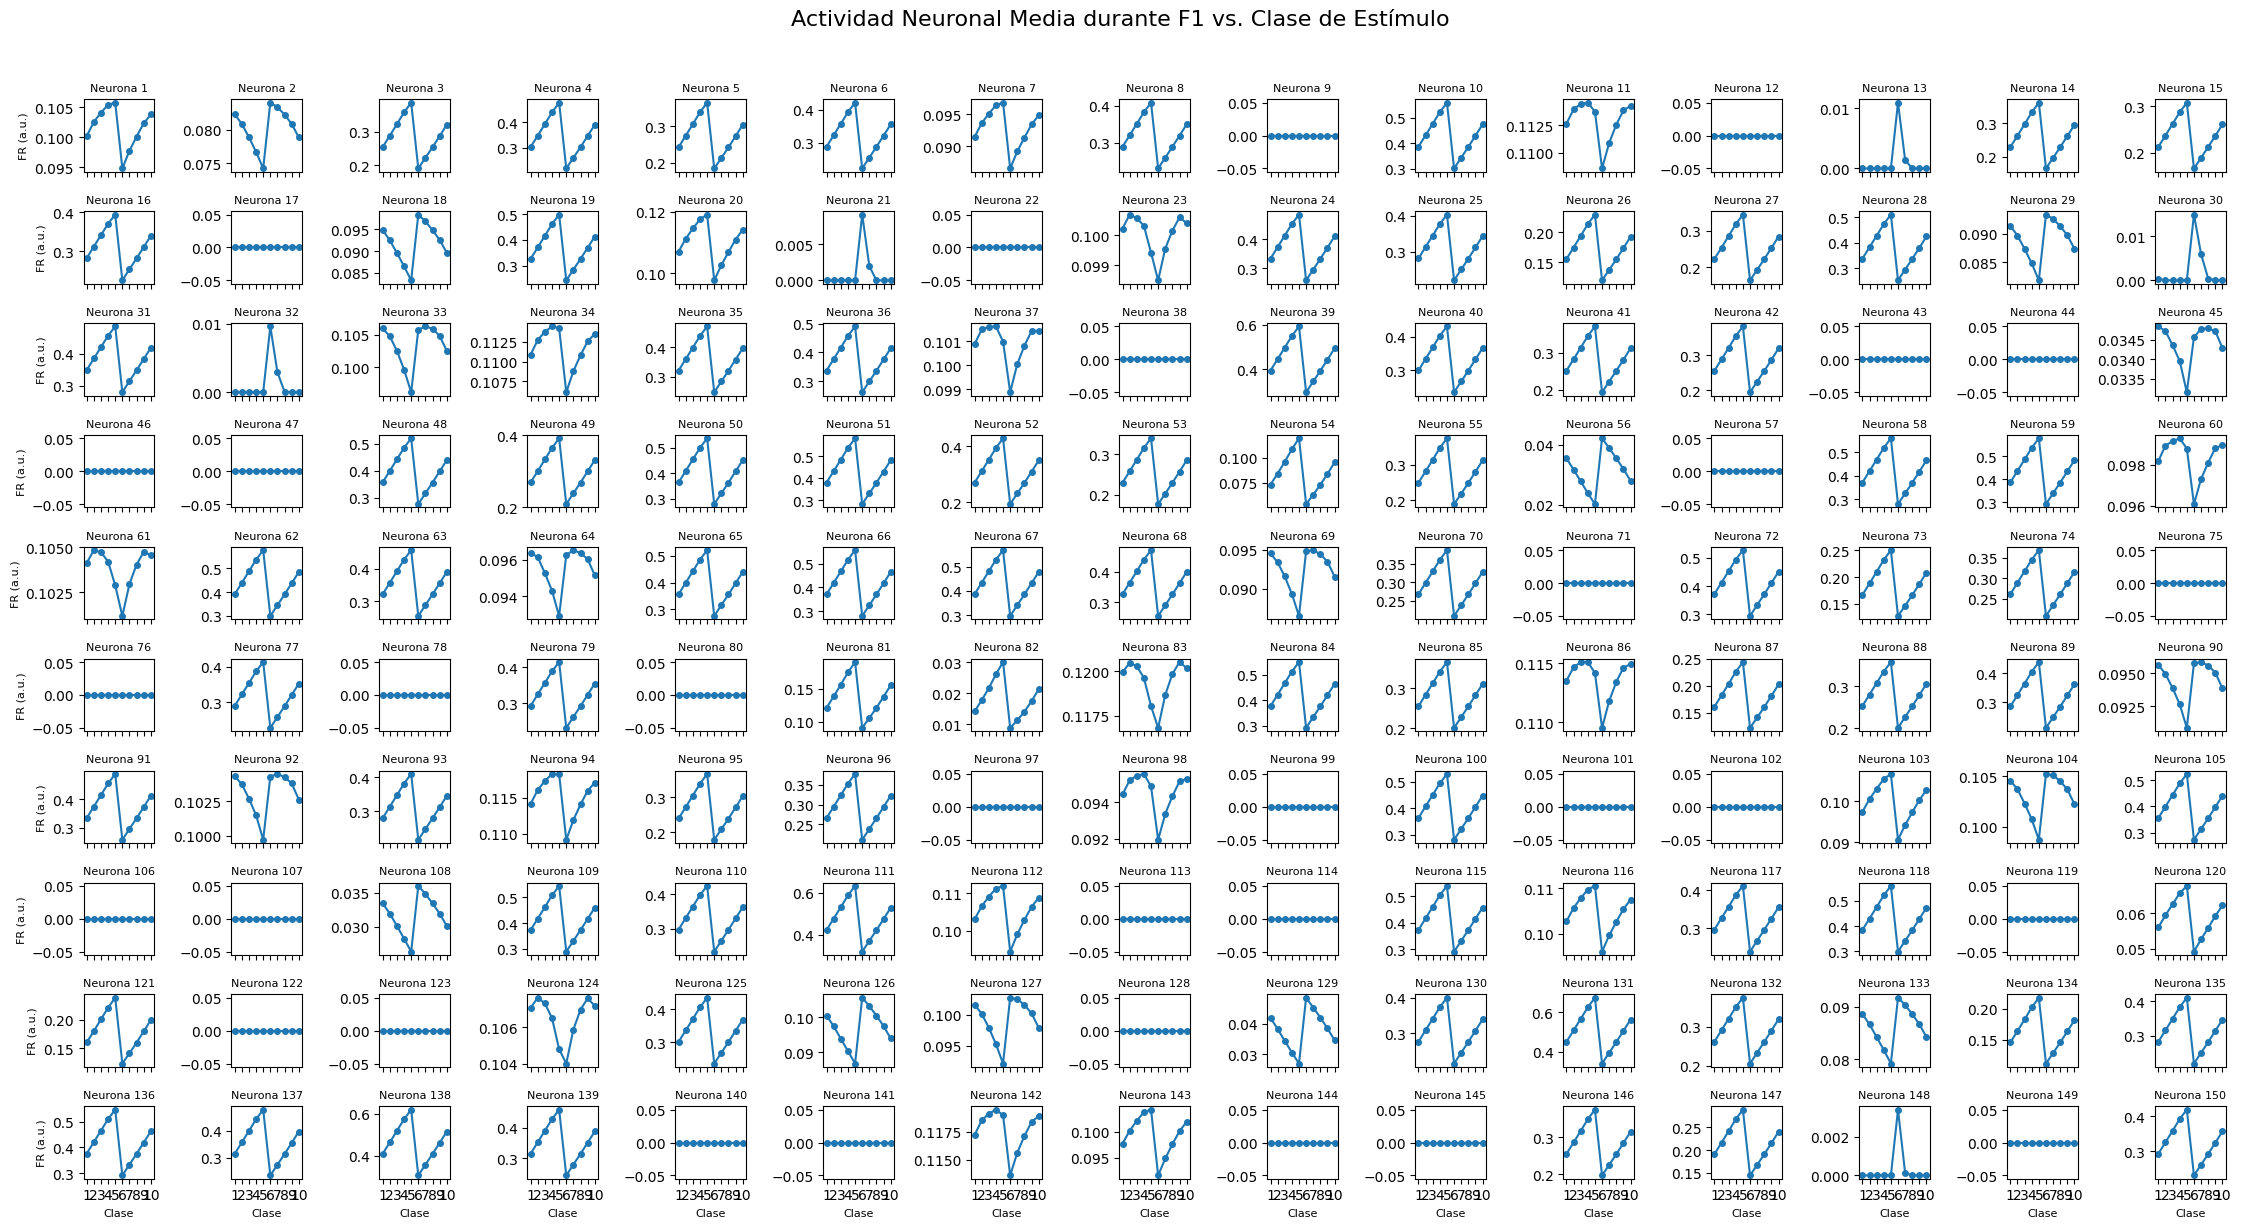

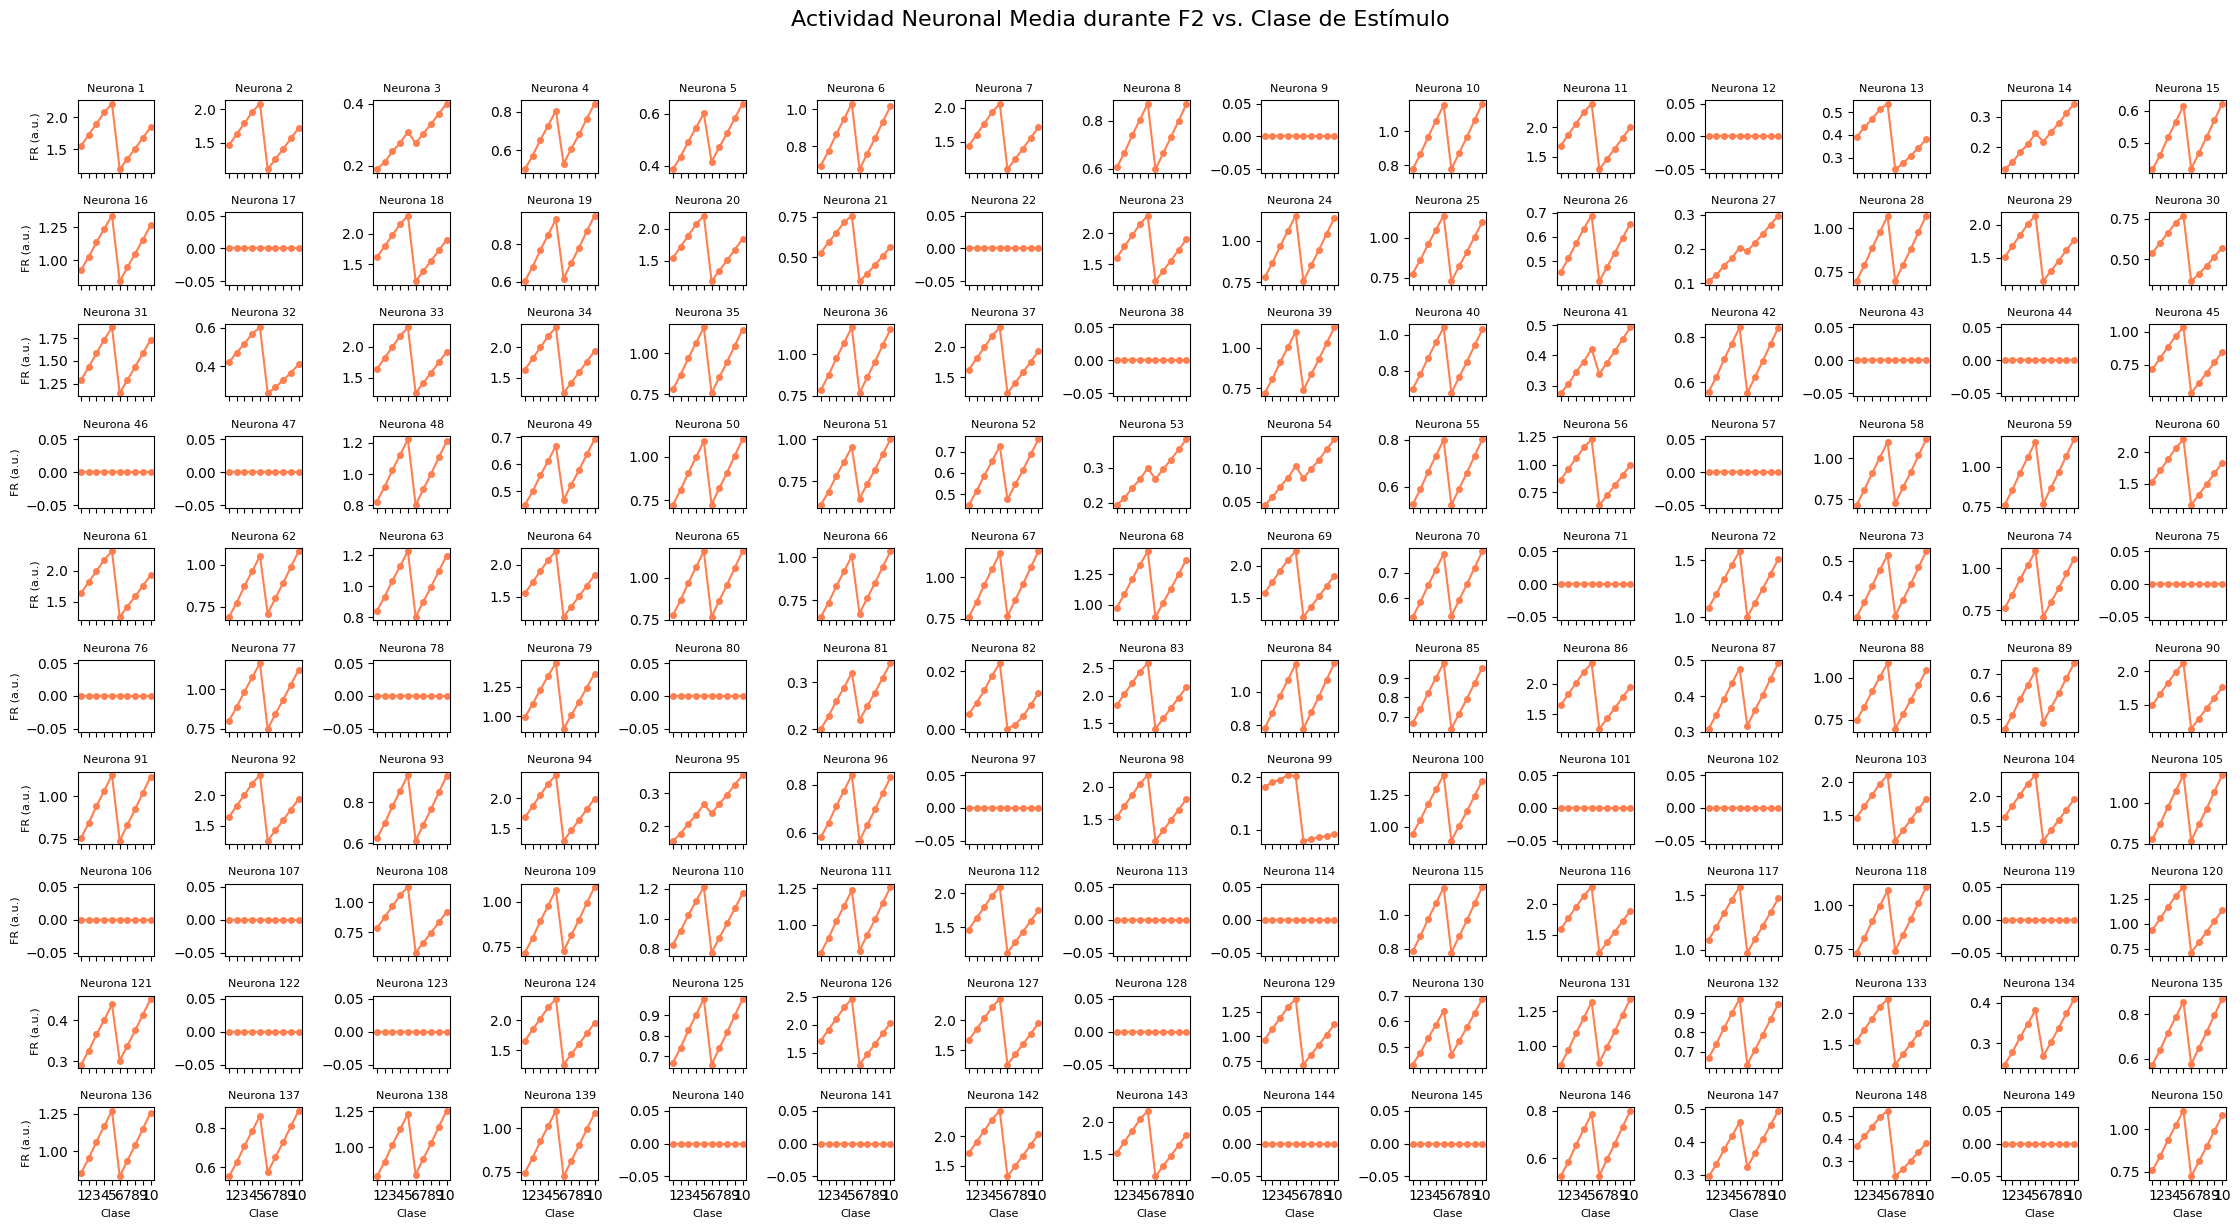


Porcentaje de acierto calculado por condición:
     f1    f2  is_correct  percentage
0  10.0  18.0    0.955752          95
1  14.0  22.0    1.000000         100
2  18.0  10.0    0.976744          97
3  18.0  26.0    0.981651          98
4  22.0  14.0    0.927835          92
5  22.0  30.0    0.960000          96
6  26.0  18.0    0.982301          98
7  26.0  34.0    0.962500          96
8  30.0  22.0    0.972222          97
9  34.0  26.0    1.000000         100


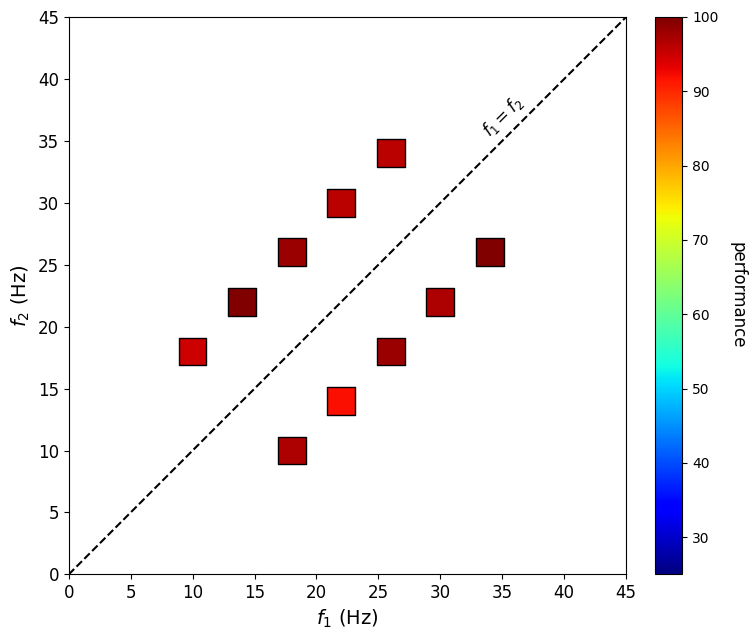


Rendimiento por Número de Clase:
   class_number      mean       sem   mean_perc  sem_perc
0             1  0.962500  0.021375   96.250000  2.137482
1             2  0.960000  0.022780   96.000000  2.277979
2             3  0.981651  0.012914   98.165138  1.291423
3             4  1.000000  0.000000  100.000000  0.000000
4             5  0.955752  0.019432   95.575221  1.943164
5             6  1.000000  0.000000  100.000000  0.000000
6             7  0.972222  0.015887   97.222222  1.588692
7             8  0.982301  0.012459   98.230088  1.245917
8             9  0.927835  0.026410   92.783505  2.640967
9            10  0.976744  0.016347   97.674419  1.634733


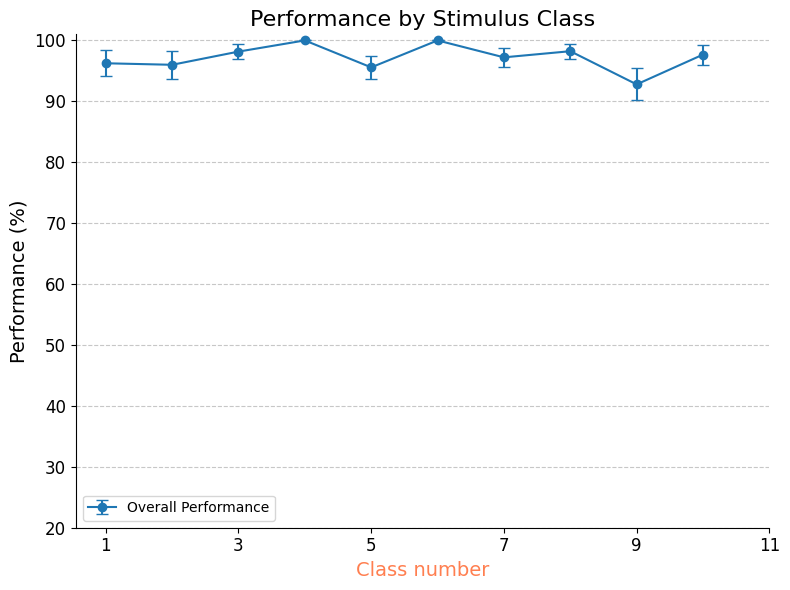

In [ ]:
config = {
        "dt": 10,
        "reward_correct": 1.0,
        "reward_incorrect": 0.0,
        "reward_aborted": -1.0,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.1,
        "reward_decide_fixation": -0.1,
        "duration_params": [10, 10, 10, 10, 10, 10], 
        "actor_hidden_size": 150,
        "critic_hidden_size": 150,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        "print_interval": 100,
        "record_history": True
    }

# --- Cargar resultados para análisis ---
output_dir = Path.cwd() / "outputs"
output_file = output_dir / "WM+_F_rnn_5.pkl"

print(f"\nLoading results from {output_file} for plotting...")
with open(output_file, "rb") as f:
    (
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        actor_firing_rates,
        critic_firing_rates,
        other_measurements
    ) = pickle.load(f)

# --- Determinar los timesteps para F1 y F2 a partir de la configuración ---
dt = config["dt"]
duration_params = config["duration_params"]

# Convertir duraciones en ms a pasos de tiempo
def _ms_to_steps(ms, dt):
    return max(1, int(round(ms / dt))) if ms > 0 else 0

t_fix_steps = _ms_to_steps(duration_params[0], dt)
t_f1_steps = _ms_to_steps(duration_params[2], dt)
t_delay_steps = _ms_to_steps(duration_params[3], dt)

# El estímulo F1 ocurre después del período de fijación.
f1_start_step = t_fix_steps
f1_end_step = f1_start_step + t_f1_steps
f1_timesteps = range(f1_start_step, f1_end_step)

# El estímulo F2 ocurre después de F1 y el delay.
f2_start_step = f1_end_step + t_delay_steps
f2_end_step = f2_start_step + _ms_to_steps(duration_params[4], dt)
f2_timesteps = range(f2_start_step, f2_end_step)

print(f"Timesteps para F1: {list(f1_timesteps)}")
print(f"Timesteps para F2: {list(f2_timesteps)}")

# --- Llamar a la nueva función de visualización ---
print("\nPlotting neural activity by stimulus class...")
if actor_firing_rates is not None:
    plot_activity_by_stimulus_class(
        all_measurements=other_measurements,
        firing_rates=actor_firing_rates,
        f1_timesteps=f1_timesteps,
        f2_timesteps=f2_timesteps,
        n_rows=10,
        n_cols=15
    )
else:
    print("No se encontraron datos de actividad del actor para graficar.")

plot_performance_matrix(other_measurements)

sesgo_contraccion(other_measurements)